In [358]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, glob, time
import itertools, functools

from scipy import stats
from scipy.special import logit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, mutual_info_score
                                                                                                                                
from matplotlib.patches import Rectangle, Circle, Polygon
from matplotlib.lines import Line2D

In [363]:
def postprocess(df_sr,df_sb,R_cutoff=5, R_cutoff_low=-5):
    print(df_sr.columns)
    auxillary = ['label'] + [col for col in df_sr.columns if col.startswith('_')]
    lam = df_sb.LL - df_sr.LL
    R = df_sr.LL - df_sb.LL
    print('R max', R.max())
    print('R min', R.min())
    df_agg = pd.concat([df_sr[auxillary], R, df_sr.LL, df_sb.LL, lam], axis=1)#, columns=auxillary+['R','log_px_data',log_px_bkg'])
    df_agg.columns=auxillary+['R','log_px_data','log_px_bkg','lam']
    df_agg.columns = [c.replace('_','-') for c in df_agg.columns]
    df_agg = df_agg[R<R_cutoff]
    print('Surviving after R<{} cut'.format(R_cutoff), df_agg.shape[0]/df_sr.shape[0])
    df_agg = df_agg[R>R_cutoff_low]
    print('Surviving after R>{} cut'.format(R_cutoff_low), df_agg.shape[0]/df_sr.shape[0])

    df_agg_sig, df_agg_bkg = df_agg[df_agg.label > 0.5], df_agg[df_agg.label < 0.5]
    
    roc_auc_i = roc_auc_score(df_agg.label, df_agg.R)
    print('AUROC using R', roc_auc_i)
    
    return df_agg, df_agg_sig, df_agg_bkg

def all_eval2(dfs):
    EPS = 1e-3
    roc_aucs, sig_R, bkg_R, lam_sep = [], [], [], []
    for i,df in enumerate(dfs):
        # df['laambda'] = np.reciprocal(df.R+EPS)
        # df['laambda'] = np.reciprocal(df.R+EPS)
        avg_lam_sep = df.lam.mean()
        df_sig = df[df.label>0.5]
        df_bkg = df[df.label<0.5]
        if i == 0:
            sns.distplot(df_sig.R, bins=30)
            sns.distplot(df_bkg.R, bins=30)
            plt.xlim((0,10))
        roc_auc_i = roc_auc_score(df.label, df.R)
        roc_aucs.append(roc_auc_i)
        sig_R.append(np.exp(df_sig.lam).mean())
        bkg_R.append(np.exp(df_bkg.lam).mean())
        lam_sep.append(avg_lam_sep)
        
    roc_aucs = np.array(roc_aucs)
    sig_R = np.array(sig_R)
    bkg_R = np.array(bkg_R)
    delta = bkg_R - sig_R
    lam_sep = np.array(lam_sep)
    print('AUROC using R {:.3f} +/- {:.3f}'.format(roc_aucs.mean(), roc_aucs.std()))
    print('Sig R {:.3f} +/- {:.3f}'.format(sig_R.mean(), sig_R.std()))
    print('Bkg R {:.3f} +/- {:.3f}'.format(bkg_R.mean(), bkg_R.std()))
    print('Delta R {:.3f} +/- {:.3f}'.format(delta.mean(), delta.std()))
    print('Delta Lambda {:.3f} +/- {:.3f}'.format(lam_sep.mean(), lam_sep.std()))

    return delta, roc_aucs


In [3]:
filenames_all_iwae16 = glob.glob('experiments/iwae_16_all*/*.hdf')
filenames_all_rnvp = glob.glob('experiments/nvp_all*/*.hdf')
filenames_all_maf = glob.glob('experiments/maf_all_pd*/*.hdf')
filenames_all_iwae1024 = glob.glob('experiments/iwae__*/*.hdf')
filenames_all_iwae1024 = filenames_all_iwae1024[:2]+[filenames_all_iwae1024[-1]]

filenames_all_sumo = glob.glob('experiments/sumo__*/*.hdf')
filenames_all_sumo.extend(glob.glob('experiments/sumo_rv_all_pd*/*.hdf'))
filenames_all_ffjord = glob.glob('experiments/cnf_approx_2b_*all*/*.hdf')


In [3]:
filenames_all_ffjord

['experiments/cnf_approx_2b_tanh_jets_all_pd_T5_jets_cnf_2020_07_07_11_03/flow_metrics_cnf_approx_2b_tanh_jets_all_pd_T5_jets_cnf_2020_07_07_11_03_all.hdf',
 'experiments/cnf_approx_2b_tanh_jets_all_pd_T7_jets_cnf_2020_07_07_04_32/flow_metrics_cnf_approx_2b_tanh_jets_all_pd_T7_jets_cnf_2020_07_07_04_32_all.hdf',
 'experiments/cnf_approx_2b_tanh_jets_all_pd_T3_jets_cnf_2020_07_07_08_25/flow_metrics_cnf_approx_2b_tanh_jets_all_pd_T3_jets_cnf_2020_07_07_08_25_all.hdf',
 'experiments/cnf_approx_2b_tanh_jets_all_pd_T9_jets_cnf_2020_07_07_12_54/flow_metrics_cnf_approx_2b_tanh_jets_all_pd_T9_jets_cnf_2020_07_07_12_54_all.hdf',
 'experiments/cnf_approx_2b_tanh_jets_all_pd_T6_jets_cnf_2020_07_07_16_05/flow_metrics_cnf_approx_2b_tanh_jets_all_pd_T6_jets_cnf_2020_07_07_16_05_all.hdf',
 'experiments/cnf_approx_2b_tanh_jets_all_pd_T2_jets_cnf_2020_07_07_04_27/flow_metrics_cnf_approx_2b_tanh_jets_all_pd_T2_jets_cnf_2020_07_07_04_27_all.hdf',
 'experiments/cnf_approx_2b_tanh_jets_all_pd_T4_jets_cnf_2

In [4]:
filenames_all_sumo

['experiments/sumo__jets_no_flow_2020_07_06_21_36/flow_metrics_sumo__jets_no_flow_2020_07_06_21_36_all.hdf',
 'experiments/sumo__jets_no_flow_2020_07_06_18_57/flow_metrics_sumo__jets_no_flow_2020_07_06_18_57_all.hdf',
 'experiments/sumo_rv_all_pd_T2_jets_no_flow_2020_07_07_07_14/flow_metrics_sumo_rv_all_pd_T2_jets_no_flow_2020_07_07_07_14_all.hdf',
 'experiments/sumo_rv_all_pd_T3_jets_no_flow_2020_07_07_13_20/flow_metrics_sumo_rv_all_pd_T3_jets_no_flow_2020_07_07_13_20_all.hdf',
 'experiments/sumo_rv_all_pd_T1_jets_no_flow_2020_07_07_01_06/flow_metrics_sumo_rv_all_pd_T1_jets_no_flow_2020_07_07_01_06_all.hdf',
 'experiments/sumo_rv_all_pd_T2_jets_no_flow_2020_07_07_07_06/flow_metrics_sumo_rv_all_pd_T2_jets_no_flow_2020_07_07_07_06_all.hdf',
 'experiments/sumo_rv_all_pd_T3_jets_no_flow_2020_07_07_13_12/flow_metrics_sumo_rv_all_pd_T3_jets_no_flow_2020_07_07_13_12_all.hdf']

In [ ]:
[df_agg_nvps, df_agg_mafs, df_agg_ffjords, df_agg_iwaes, df_agg_sumos]

In [400]:
df_agg_mafs[2].R.min()

6.266222651873932e-09

In [5]:
from scipy.optimize import bisect

In [46]:
def get_threshold(test_statistic, nominal_alpha):
    """
    Calculates threshold (epsilon) on test statistic for fixed
    false positive rate (nominal_alpha)
    """
    def alpha_search(test_statistic, nominal_alpha):

        def _f(x, test_statistic, nominal_alpha):
            # Probability of Type I error
            summand = np.where(test_statistic > x, test_statistic, np.zeros_like(test_statistic))
            alpha = np.mean(summand).item()
            return (alpha - nominal_alpha)

        result = bisect(_f, 0.5, 4., args=(test_statistic, nominal_alpha), full_output=True) 
        return result[0] 

    threshold = alpha_search(test_statistic, nominal_alpha)
    return threshold

In [47]:
df = df_agg_mafs[0]

NameError: name 'df_agg_mafs' is not defined

In [132]:
get_threshold(df.R, 0.1)

1.1800978779796765

AUROC using R 0.853 +/- 0.005
Sig R 0.761 +/- 0.011
Bkg R 1.009 +/- 0.001
Delta R 0.248 +/- 0.010


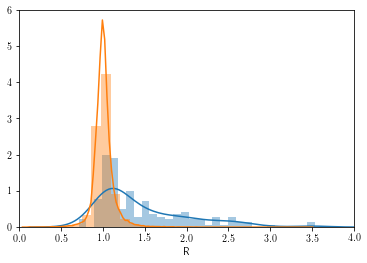

In [76]:
delta_nvp, roc_nvp = all_eval2(df_agg_nvps)

AUROC using R 0.840 +/- 0.002
Sig R 0.740 +/- 0.006
Bkg R 1.063 +/- 0.007
Delta R 0.323 +/- 0.007


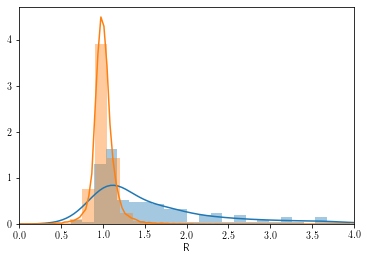

In [77]:
delta_maf, roc_maf = all_eval2(df_agg_mafs)

AUROC using R 0.899 +/- 0.002
Sig R 0.549 +/- 0.006
Bkg R 1.016 +/- 0.014
Delta R 0.467 +/- 0.012


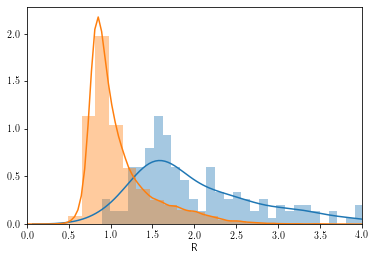

In [78]:
delta_iwae, roc_iwae = all_eval2(df_agg_iwaes)

AUROC using R 0.841 +/- 0.020
Sig R 0.647 +/- 0.036
Bkg R 1.069 +/- 0.013
Delta R 0.422 +/- 0.026


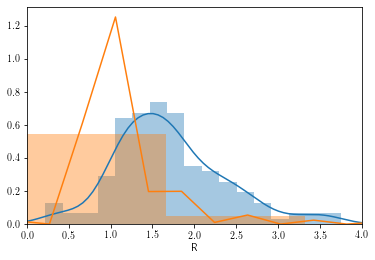

In [79]:
delta_sumo, roc_sumo = all_eval2(df_agg_sumos)

AUROC using R 0.900 +/- 0.018
Sig R 0.569 +/- 0.040
Bkg R 1.035 +/- 0.009
Delta R 0.466 +/- 0.036


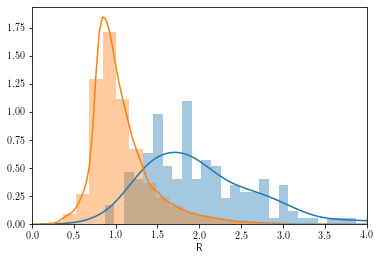

In [80]:
delta_ffjord, roc_ffjord = all_eval2(df_agg_ffjords_new)

In [74]:
for model in ['sumo', 'iwae', 'ffjord', 'nvp', 'maf']:
    out = unpaired_t_test(roc_ffjord, eval('roc_{}'.format(model)))
    print(out)
    if out[-1] > 0.05:
        print('cannot reject null hypothesis of equal means from {}'.format(model))

NameError: name 'unpaired_t_test' is not defined

In [8]:
def all_eval(fnames):
    dfs = [pd.read_hdf(f) for f in fnames]
    storages = [glob.glob(os.path.join(os.path.dirname(f),'storage/storage*.pkl'))[0] for f in fnames]
    ps = [pd.read_pickle(s) for s in storages]
    bpds = []
    for p in ps:
        t = np.array(p['time'])[2:]
        t = (t-t[0])/3600.
        bpd = -np.array(p['log_prob_per_dim'])[2:]
        bpds.append(bpd)

    roc_aucs, sig_LL, bkg_LL, ovr_LL = [], [], [], []
    for i,df in enumerate(dfs):
        df_sig = df[df.label>0.5]
        df_bkg = df[df.label<0.5]
        if i == 0:
            sns.distplot(df_sig.LL)
            sns.distplot(df_bkg.LL)
        roc_auc_i = roc_auc_score(df.label, -df.LL)
        roc_aucs.append(roc_auc_i)
        sig_LL.append(df_sig.LL.mean())
        bkg_LL.append(df_bkg.LL.mean())
        ovr_LL.append(df.LL.mean())
    
    roc_aucs = np.array(roc_aucs)
    ovr_bpd = -np.array(ovr_LL)/(4*np.log(2))
    sig_LL = -np.array(sig_LL)/(4*np.log(2))
    bkg_LL = -np.array(bkg_LL)/(4*np.log(2))
    delta = bkg_LL - sig_LL
    print('ovr bpd {:.3f} +/- {:.3f}'.format(ovr_bpd.mean(), ovr_bpd.std()))
    print('AUROC using LL {:.3f} +/- {:.3f}'.format(roc_aucs.mean(), roc_aucs.std()))
    print('Sig LL {:.3f} +/- {:.3f}'.format(sig_LL.mean(), sig_LL.std()))
    print('Bkg LL {:.3f} +/- {:.3f}'.format(bkg_LL.mean(), bkg_LL.std()))
    print('Delta LL {:.3f} +/- {:.3f}'.format(delta.mean(), delta.std()))
    
    return ovr_bpd, roc_aucs, delta

In [458]:
dfiwae1024.columns

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')

In [486]:
stats.ttest_ind?

Signature: stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')
Docstring:
Calculate the T-test for the means of *two independent* samples of scores.

This is a two-sided test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.

Parameters
----------
a, b : array_like
    The arrays must have the same shape, except in the dimension
    corresponding to `axis` (the first, by default).
axis : int or None, optional
    Axis along which to compute test. If None, compute over the whole
    arrays, `a`, and `b`.
equal_var : bool, optional
    If True (default), perform a standard independent 2 sample test
    that assumes equal population variances [1]_.
    If False, perform Welch's t-test, which does not assume equal
    population variance [2]_.

    .. versionadded:: 0.11.0
nan_policy : {'propagate', 'raise', 'omit'}, optional
    Defines how to handle whe

In [9]:
def unpaired_t_test(a, b):
    print('a: {} +/- {}'.format(a.mean(), a.std()))
    print('b: {} +/- {}'.format(b.mean(), b.std()))
    return stats.ttest_ind(a, b, equal_var=False)

In [499]:
for model in ['iwae16', 'sumo', 'iwae1024', 'ffjord', 'nvp', 'maf']:
    out = unpaired_t_test(roc_aucs_nvp, eval('roc_aucs_{}'.format(model)))
    print(out)
    if out[-1] > 0.05:
        print('cannot reject null hypothesis of equal means from {}'.format(model))

a: 0.8262233027192508 +/- 0.00030598037953828374
b: 0.8135416291494089 +/- 0.00218276655061128
Ttest_indResult(statistic=8.136893273849445, pvalue=0.01317423673785804)
a: 0.8262233027192508 +/- 0.00030598037953828374
b: 0.8179328891289993 +/- 0.0014646476662189115
Ttest_indResult(statistic=10.856776078019616, pvalue=0.00017515243159919695)
a: 0.8262233027192508 +/- 0.00030598037953828374
b: 0.8153616663665287 +/- 0.0009856211464665515
Ttest_indResult(statistic=14.884030838328107, pvalue=0.0020908030887221473)
a: 0.8262233027192508 +/- 0.00030598037953828374
b: 0.8163933209276267 +/- 0.003089463410198257
Ttest_indResult(statistic=7.02900663631905, pvalue=0.0007404079091035705)
a: 0.8262233027192508 +/- 0.00030598037953828374
b: 0.8262233027192508 +/- 0.00030598037953828374
Ttest_indResult(statistic=0.0, pvalue=1.0)
cannot reject null hypothesis of equal means from nvp
a: 0.8262233027192508 +/- 0.00030598037953828374
b: 0.8066299697861016 +/- 0.0003001521870071378
Ttest_indResult(statist

ovr bpd -0.742 +/- 0.001
AUROC using LL 0.815 +/- 0.001
Sig LL -0.067 +/- 0.007
Bkg LL -0.746 +/- 0.001
Delta LL -0.679 +/- 0.007


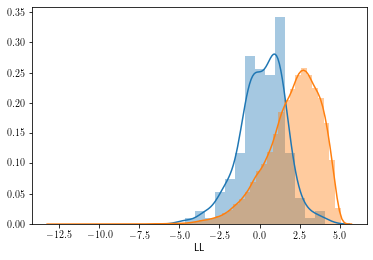

In [485]:
bpd_iwae1024, roc_aucs_iwae1024, delta_iwae1024 = all_eval(filenames_all_iwae1024)

ovr bpd -0.758 +/- 0.000
AUROC using LL 0.807 +/- 0.000
Sig LL -0.215 +/- 0.000
Bkg LL -0.761 +/- 0.000
Delta LL -0.547 +/- 0.000


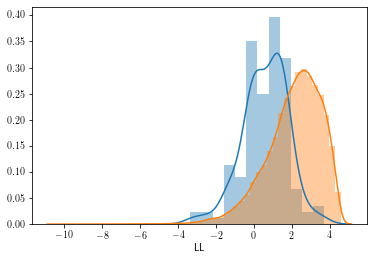

In [484]:
bpd_maf, roc_aucs_maf, delta_maf = all_eval(filenames_all_maf)

In [56]:
def postprocess(df_sr,df_sb,R_cutoff=5):
    print(df_sr.columns)
    auxillary = ['label'] + [col for col in df_sr.columns if col.startswith('_')]
    R = df_sr.LL - df_sb.LL
    print('R max', R.max())
    print('R min', R.min())
    df_agg = pd.concat([df_sr[auxillary], R, df_sr.LL, df_sb.LL], axis=1)#, columns=auxillary+['R','log_px_data',log_px_bkg'])
    df_agg.columns=auxillary+['R','log_px_data','log_px_bkg']
    df_agg.columns = [c.replace('_','-') for c in df_agg.columns]
    df_agg = df_agg[R<R_cutoff]
    print('Surviving after R<{} cut'.format(R_cutoff), df_agg.shape[0]/df_sr.shape[0])
    df_agg_sig, df_agg_bkg = df_agg[df_agg.label > 0.5], df_agg[df_agg.label < 0.5]
    
    roc_auc_i = roc_auc_score(df_agg.label, df_agg.R)
    print('AUROC using R', roc_auc_i)
    
    return df_agg, df_agg_sig, df_agg_bkg

In [366]:
df_data = pd.read_hdf('experiments/iwae_double_16_jets_no_flow_2020_07_10_17_15/flow_metrics_iwae_double_16_jets_no_flow_2020_07_10_17_15_______________data_all.hdf')

In [367]:
df_bkg = pd.read_hdf('experiments/iwae_double_16_jets_no_flow_2020_07_10_17_15/flow_metrics_iwae_double_16_jets_no_flow_2020_07_10_17_15_______________data_bkg_all.hdf')

In [491]:
df_agg = postprocess(df_sb, df_sr, R_cutoff=1000)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 3.213834285736084
R min -4.421609878540039
Surviving after R<1000 cut 1.0
Surviving after R>-5 cut 1.0
AUROC using R 0.2652399576248681


In [487]:
df_sb = pd.read_hdf('experiments/sb_iwae_32_jets_no_flow_2020_07_14_03_42/flow_metrics_sb_iwae_32_jets_no_flow_2020_07_14_03_42__SB.hdf')
df_sr = pd.read_hdf('experiments/sr_iwae_32_jets_no_flow_2020_07_14_03_42/flow_metrics_sr_iwae_32_jets_no_flow_2020_07_14_03_42__SR.hdf')

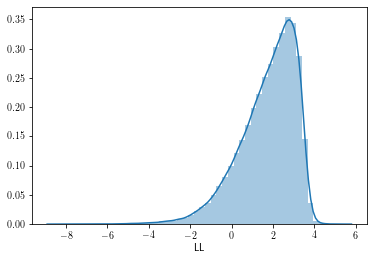

In [488]:
sns.distplot(df_sb.LL)

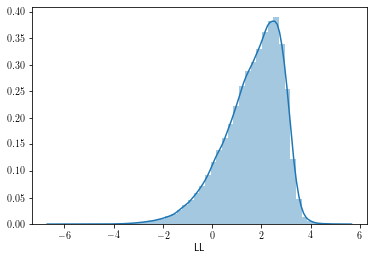

In [489]:
sns.distplot(df_sr.LL)

In [490]:
df = pd.read_hdf('experiments/iwae_32_jets_no_flow_2020_07_13_23_24/flow_metrics_iwae_32_jets_no_flow_2020_07_13_23_24__all.hdf')
df.columns = [col.replace('_','-') for col in df.columns]
df.columns

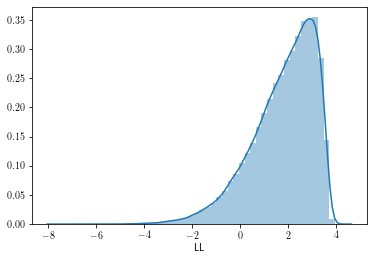

In [478]:
sns.distplot(df.LL)

In [527]:
qs = np.linspace(0.01,0.51,11)
thresholds = np.quantile(df.LL.values, q=qs)
print(qs)
print(thresholds)

[0.01 0.06 0.11 0.16 0.21 0.26 0.31 0.36 0.41 0.46 0.51]
[-2.13275711 -0.5619133   0.04430414  0.46236799  0.79365268  1.06736797
  1.29982285  1.51545189  1.71779355  1.9030946   2.07778499]


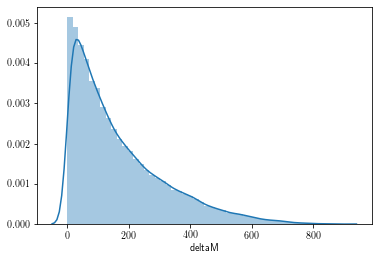

In [519]:
sns.distplot(df.deltaM)

In [520]:
df_sig = df[df.label > 0.5]

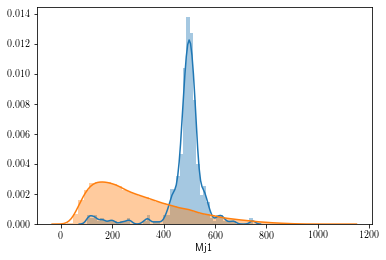

In [524]:
sns.distplot(df_sig.Mj1)
sns.distplot(df_bkg.Mj1)

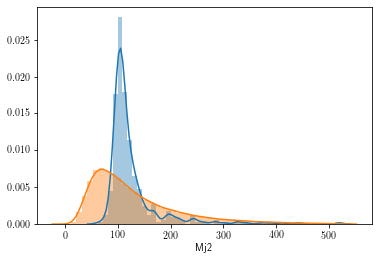

In [526]:
sns.distplot(df_sig.Mj2)
sns.distplot(df_bkg.Mj2)

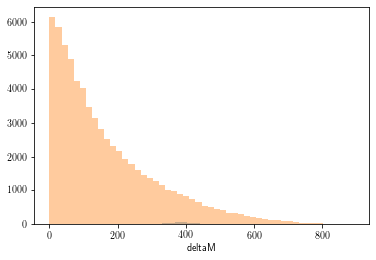

In [530]:
sns.distplot(df_sig.deltaM, kde=False)
sns.distplot(df_bkg.deltaM, kde=False)

-2.1327571105957035


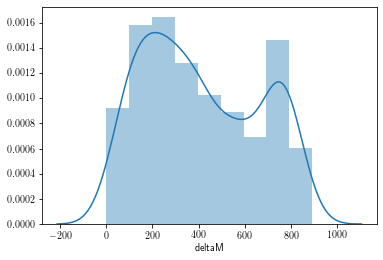

No handles with labels found to put in legend.


-0.5619132995605469


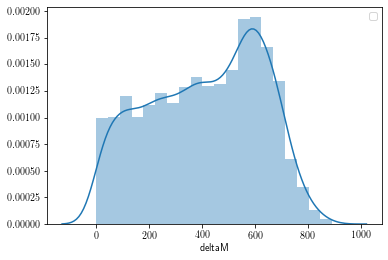

No handles with labels found to put in legend.


0.044304141998291


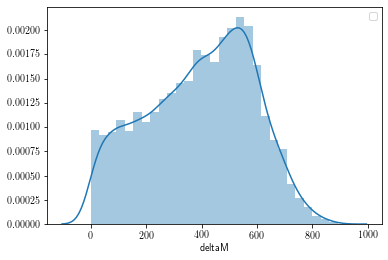

No handles with labels found to put in legend.


0.46236799240112353


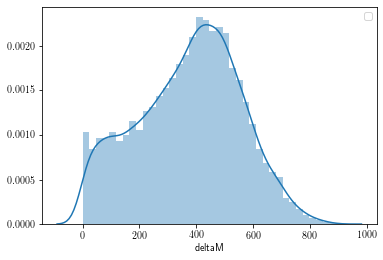

No handles with labels found to put in legend.


0.7936526775360109


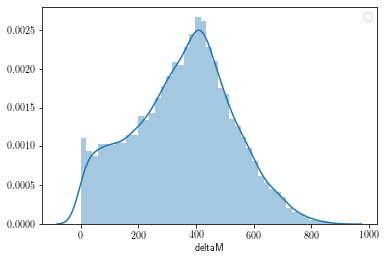

No handles with labels found to put in legend.


1.0673679733276367


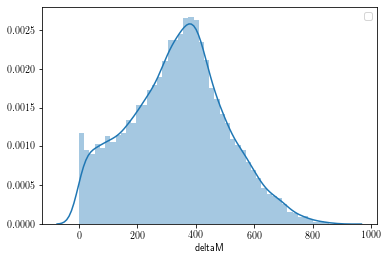

No handles with labels found to put in legend.


1.2998228549957276


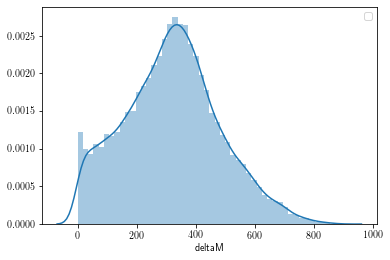

No handles with labels found to put in legend.


1.515451889038086


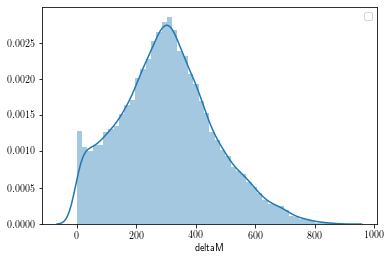

No handles with labels found to put in legend.


1.7177935504913333


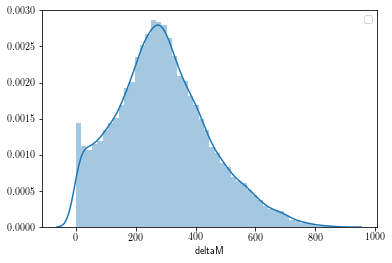

No handles with labels found to put in legend.


1.9030945968627933


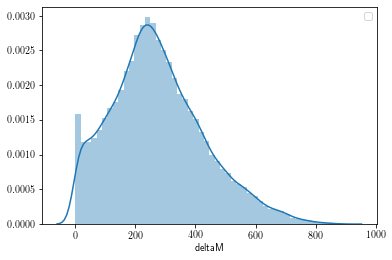

No handles with labels found to put in legend.


2.0777849864959714


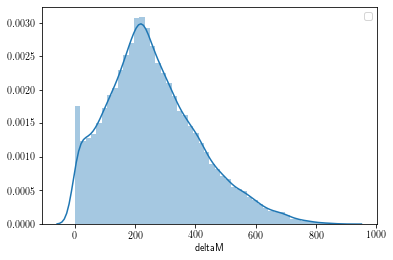

No handles with labels found to put in legend.


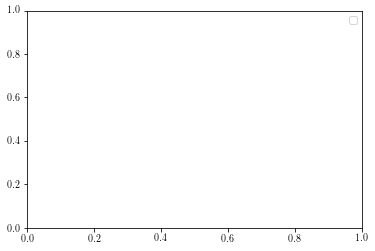

In [522]:
var = 'deltaM'
# var = '-Mjj'
for q, threshold in zip(qs, thresholds):
    print(threshold)
    tmp_df = df[df.LL < threshold]
    sns.distplot(tmp_df[var])
#     tmp_df_sig = tmp_df[tmp_df.label > 0.5]
#     tmp_df_bkg = tmp_df[tmp_df.label < 0.5]
#     sns.distplot(tmp_df_sig[var], label='Sig q{}'.format(q), norm_hist=False, kde=False)
#     sns.distplot(tmp_df_bkg[var], label='Bkg q{}'.format(q), norm_hist=False, kde=False)
#     plt.yscale('log')
    plt.show()
    plt.legend()
    # plt.clf()

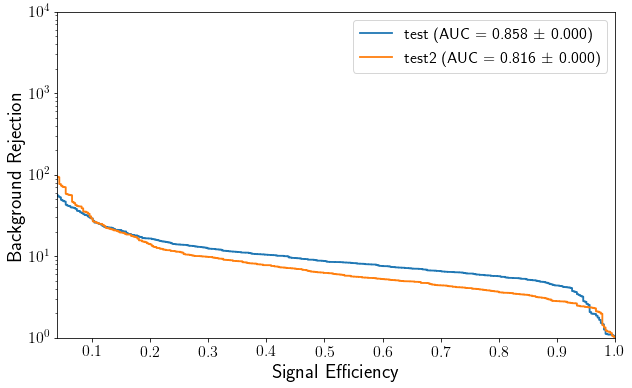

In [412]:
plot_eff_multiple_nested([df, df_data], labels=['test', 'test2'],
                         upper_y=1e4, title='born2run', save_path='test.pdf')

In [411]:
def plot_eff_multiple_nested(nested_dfs, labels, title='born2run', save_path='eff_comp.pdf', upper_y=1e5):

    def _boundaries(arrays):
        sizes = [a.shape[0] for a in arrays]
        a_primary = arrays[np.argmax(sizes)]
        a_min = np.empty(a_primary.shape[0])
        a_max = np.empty(a_primary.shape[0])

        for i in range(a_primary.shape[0]):

            try:
                elemwise = [a[i] for a in arrays]
                max_element = max(elemwise)
                min_element = min(elemwise)
                a_min[i] = min_element
                a_max[i] = max_element

            except IndexError:
                a_min[i] = a_primary[i]
                a_max[i] = a_primary[i]

        return a_min, a_max
    
    def _averaging(arrays):
        sizes = [a.shape[0] for a in arrays]
        a_primary = arrays[np.argmax(sizes)]
        a_avg = np.empty(a_primary.shape[0])
        a_std = np.empty(a_primary.shape[0])


        for i in range(a_primary.shape[0]):

            try:
                mean = np.mean([a[i] for a in arrays])
                std = np.std([a[i] for a in arrays])
                a_avg[i] = mean
                a_std[i] = std

            except IndexError:
                a_avg[i] = a_primary[i]
                a_std[i] = 0.0

        return a_avg, a_std
    

    # plt.figure()
    plt.figure(figsize=(10,6))
    plt.tick_params(axis='both', which='major', labelsize=16)

#    plt.axes([.1,.1,.8,.78])
#     plt.figtext(.5,.9, title, fontsize=22, ha='center')
#     plt.figtext(.5,.85, r'$b \rightarrow s \gamma$, Decorrelation comparison', fontsize=18,ha='center')
#    plt.figtext(.5,.9, r'$b \rightarrow s \gamma$, Decorrelation comparison', fontsize=18,ha='center')
    
    xcolors = ["denim blue", "medium green","pale red"]
    # palette = itertools.cycle(sns.xkcd_palette())
    # palette = itertools.cycle(sns.cubehelix_palette(8, start=.5, rot=-.75))
    # palette = itertools.cycle(sns.color_palette("hls", 8))
    palette = itertools.cycle(sns.color_palette())

    for (dfs, label) in zip(nested_dfs, labels):
        if not isinstance(dfs, list):
            dfs = [dfs]

        bkg_rej_all, sig_eff_all = list(), list()
        roc_auc_all = list()

        for df in dfs:
            fpr_i, tpr_i, thresholds = roc_curve(df.label, -df.LL)
            roc_auc_i = roc_auc_score(df.label, -df.LL)
            # fpr, tpr, thresholds = roc_curve(df['y_true'], df['y_prob'])
            # roc_auc = roc_auc_score(df.y_true, df.y_prob)

            # plt.plot(fpr_i, tpr_i, lw=1.8, label='{} (area = {:.4f})'.format('dummy',roc_auc_i))

            bkg_rej_all.append(1/(fpr_i + 1e-10))
            sig_eff_all.append(tpr_i)
            roc_auc_all.append(roc_auc_i)

        roc_auc_mean = np.mean(roc_auc_all)
        roc_auc_std = np.std(roc_auc_all)

        br_avg, br_std = _averaging(bkg_rej_all)
        se_avg, se_std = _averaging(sig_eff_all)
        
        color = next(palette)
        plt.plot(se_avg, br_avg, lw=1.8, label='{} (AUC = {:.3f} $\pm$ {:.3f})'.format(label, roc_auc_mean, roc_auc_std), color=color)
        plt.fill_between(se_avg, br_avg-br_std, br_avg+br_std, interpolate=True, alpha=0.25, color=color)
        
    plt.xlim([0.04, 1.0])
    plt.ylim([1.0, upper_y])
    delta = 0.1
    plt.xticks(np.arange(0.1, 1.+delta, delta))
    
    plt.yscale('log', nonposy='clip')
    plt.xlabel('Signal Efficiency', fontsize=20)
    plt.ylabel('Background Rejection', fontsize=20)
    plt.legend(loc="best", fontsize=16)
    
    plt.savefig(os.path.join('imgs', save_path), format='pdf', dpi=64, bbox_inches='tight')

In [394]:
df_agg = postprocess(df_sr, df_sb, R_cutoff=10)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 11.403118133544922
R min -4.167409896850586
Surviving after R<10 cut 0.9999850538807599
Surviving after R>-5 cut 0.9999850538807599
AUROC using R 0.8184601398293317


/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


ovr bpd -0.747 +/- 0.000
AUROC using LL 0.826 +/- 0.000
Sig LL -0.136 +/- 0.001
Bkg LL -0.750 +/- 0.000
Delta LL -0.614 +/- 0.001


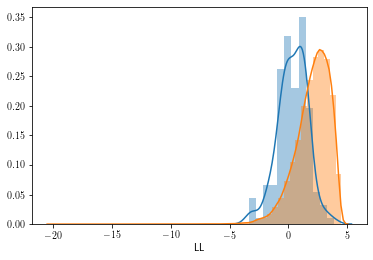

In [480]:
bpd_nvp, roc_aucs_nvp, delta_nvp = all_eval(filenames_all_rnvp)

ovr bpd -0.739 +/- 0.001
AUROC using LL 0.814 +/- 0.002
Sig LL -0.076 +/- 0.007
Bkg LL -0.743 +/- 0.001
Delta LL -0.667 +/- 0.007


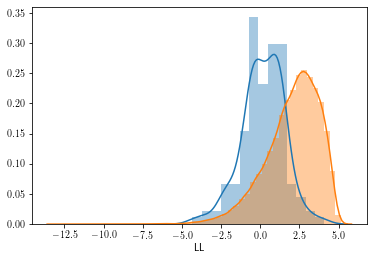

In [481]:
bpd_iwae16, roc_aucs_iwae16, delta_iwae16 = all_eval(filename_all_iwae16)

ovr bpd -0.748 +/- 0.001
AUROC using LL 0.818 +/- 0.001
Sig LL -0.147 +/- 0.005
Bkg LL -0.751 +/- 0.001
Delta LL -0.604 +/- 0.006


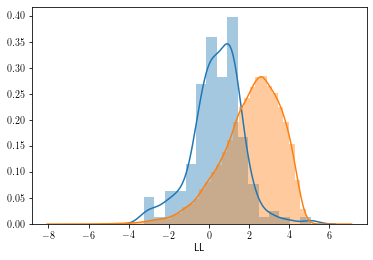

In [482]:
bpd_sumo, roc_aucs_sumo, delta_sumo = all_eval(filenames_all_sumo)

ovr bpd -0.744 +/- 0.001
AUROC using LL 0.816 +/- 0.003
Sig LL -0.065 +/- 0.019
Bkg LL -0.747 +/- 0.001
Delta LL -0.682 +/- 0.018


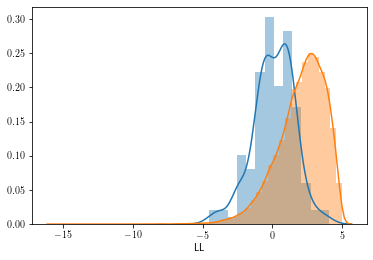

In [483]:
bpd_ffjord, roc_aucs_ffjord, delta_ffjord = all_eval(filenames_all_ffjord)

In [60]:
filename_sr_ffjord_bf1 = 'experiments/cnf_bf_1b_tanh_jets_sr_T3_jets_cnf_2020_07_06_21_07/flow_metrics_cnf_bf_1b_tanh_jets_sr_T3_jets_cnf_2020_07_06_21_07_SR.hdf'
filename_sb_ffjord_bf1 = 'experiments/cnf_bf_1b_tanh_jets_sb_T1_jets_cnf_2020_07_06_20_11/flow_metrics_cnf_bf_1b_tanh_jets_sb_T1_jets_cnf_2020_07_06_20_11_SB.hdf'
filename_sr_ffjord_bf2 = 'experiments/cnf_bf_1b_tanh_jets_sr_T2_jets_cnf_2020_07_06_20_38/flow_metrics_cnf_bf_1b_tanh_jets_sr_T2_jets_cnf_2020_07_06_20_38_SR.hdf'
filename_sb_ffjord_bf2 = 'experiments/cnf_bf_1b_tanh_jets_sb_T2_jets_cnf_2020_07_06_14_03/flow_metrics_cnf_bf_1b_tanh_jets_sb_T2_jets_cnf_2020_07_06_14_03_SB.hdf'
filename_sr_ffjord_bf3 = 'experiments/cnf_bf_1b_tanh_jets_sr_T1_jets_cnf_2020_07_06_20_11/flow_metrics_cnf_bf_1b_tanh_jets_sr_T1_jets_cnf_2020_07_06_20_11_SR.hdf'
filename_sb_ffjord_bf3 = 'experiments/cnf_bf_1b_tanh_jets_sb_T2_jets_cnf_2020_07_06_14_03/flow_metrics_cnf_bf_1b_tanh_jets_sb_T2_jets_cnf_2020_07_06_14_03_SB.hdf'


In [61]:
filename_sb_nvp = 'experiments/real_nvp_sig1k_sb_jets_real_nvp_2020_06_10_18_08/flow_metrics_real_nvp_sig1k_sb_jets_real_nvp_2020_06_10_18_08.hdf'
filename_sr_nvp = 'experiments/real_nvp_sig1k_sr_jets_real_nvp_2020_06_10_18_08/flow_metrics_real_nvp_sig1k_sr_jets_real_nvp_2020_06_10_18_08.hdf'
filename_sb_nvp1 = 'experiments/real_nvp_sig1k_sb_t0_jets_real_nvp_2020_06_10_23_02/flow_metrics_real_nvp_sig1k_sb_t0_jets_real_nvp_2020_06_10_23_02.hdf'
filename_sr_nvp1 = 'experiments/real_nvp_sig1k_sr_t0_jets_real_nvp_2020_06_10_23_02/flow_metrics_real_nvp_sig1k_sr_t0_jets_real_nvp_2020_06_10_23_02.hdf'
filename_sb_nvp2 = 'experiments/real_nvp_sig1k_sb_t1_jets_real_nvp_2020_06_10_23_41/flow_metrics_real_nvp_sig1k_sb_t1_jets_real_nvp_2020_06_10_23_41.hdf'
filename_sr_nvp2 = 'experiments/real_nvp_sig1k_sr_t1_jets_real_nvp_2020_06_10_23_41/flow_metrics_real_nvp_sig1k_sr_t1_jets_real_nvp_2020_06_10_23_41.hdf'


filename_sb_maf = 'experiments/maf_sb_jets_maf_2020_06_14_04_47/flow_metrics_maf_sb_jets_maf_2020_06_14_04_47.hdf'
filename_sr_maf = 'experiments/maf_sr_jets_maf_2020_06_14_04_48/flow_metrics_maf_sr_jets_maf_2020_06_14_04_48.hdf'
filename_sb_maf1 = 'experiments/maf_sig1k_sb_t0_jets_maf_2020_06_10_23_03/flow_metrics_maf_sig1k_sb_t0_jets_maf_2020_06_10_23_03.hdf'
filename_sr_maf1 = 'experiments/maf_sig1k_sr_t0_jets_maf_2020_06_10_23_03/flow_metrics_maf_sig1k_sr_t0_jets_maf_2020_06_10_23_03.hdf'
filename_sb_maf2 = 'experiments/maf_sig1k_sb_t1_jets_maf_2020_06_10_23_41/flow_metrics_maf_sig1k_sb_t1_jets_maf_2020_06_10_23_41.hdf'
filename_sr_maf2 = 'experiments/maf_sig1k_sr_t1_jets_maf_2020_06_10_23_41/flow_metrics_maf_sig1k_sr_t1_jets_maf_2020_06_10_23_41.hdf'

In [62]:
filename_sr_maf = 'experiments/sr_maf_jets_maf_2020_07_03_21_49/flow_metrics_sr_maf_jets_maf_2020_07_03_21_49_SR.hdf'
filename_sb_maf = 'experiments/sb_maf_jets_maf_2020_07_03_21_49/flow_metrics_sb_maf_jets_maf_2020_07_03_21_49_SB.hdf'

In [63]:
filename_sr_sumo = 'experiments/sumo_rv_sr_jets_no_flow_2020_07_05_15_00/flow_metrics_sumo_rv_sr_jets_no_flow_2020_07_05_15_00_all.hdf'
filename_sb_sumo = 'experiments/sumo_rv_sb_jets_no_flow_2020_07_05_15_00/flow_metrics_sumo_rv_sb_jets_no_flow_2020_07_05_15_00_SB.hdf'

In [64]:
filename_sumo = 'experiments/sumo_rv_all_jets_no_flow_2020_07_05_18_49/flow_metrics_sumo_rv_all_jets_no_flow_2020_07_05_18_49_all.hdf'
filename_iwae = 'experiments/iwae_all_jets_no_flow_2020_07_05_21_45/flow_metrics_iwae_all_jets_no_flow_2020_07_05_21_45_all.hdf'

In [65]:
filename_sb_ffjord = 'experiments/cnf_approx_2b_elu_jets_sb/cnf_jets_cnf_2020_06_11_03_34/flow_metrics_cnf_jets_cnf_2020_06_11_03_34.hdf'
filename_sr_ffjord = 'experiments/cnf_approx_2b_elu_jets_sr/cnf_jets_cnf_2020_06_11_03_34/flow_metrics_cnf_jets_cnf_2020_06_11_03_34.hdf'
filename_sb_ffjord1 = 'experiments/cnf_approx_2b_tanh_jets_sb/cnf_jets_cnf_2020_06_11_03_34/flow_metrics_cnf_jets_cnf_2020_06_11_03_34.hdf'
filename_sr_ffjord1 = 'experiments/cnf_approx_2b_tanh_jets_sr/cnf_jets_cnf_2020_06_11_03_34/flow_metrics_cnf_jets_cnf_2020_06_11_03_34.hdf'
filename_sb_ffjord2 = 'experiments/cnf_approx_2b_tanh_jets_sb_jets_cnf_2020_06_11_13_54/flow_metrics_cnf_approx_2b_tanh_jets_sb_jets_cnf_2020_06_11_13_54.hdf'
filename_sr_ffjord2 = 'experiments/cnf_approx_2b_tanh_jets_sr_jets_cnf_2020_06_11_13_54/flow_metrics_cnf_approx_2b_tanh_jets_sr_jets_cnf_2020_06_11_13_54.hdf'

In [66]:
filename_sr_vae = 'experiments/sr_vae_jets_no_flow_2020_07_03_16_37/flow_metrics_sr_vae_jets_no_flow_2020_07_03_16_37_SR.hdf'
filename_sb_vae = 'experiments/sb_vae_jets_no_flow_2020_07_03_16_37/flow_metrics_sb_vae_jets_no_flow_2020_07_03_16_37_SB.hdf'
filename_sr_vae1 = 'experiments/vae_sr_2_jets_VAE_2020_06_11_14_36/flow_metrics_vae_sr_2_jets_VAE_2020_06_11_14_36.hdf'
filename_sb_vae1 = 'experiments/vae_sb_2_jets_VAE_2020_06_11_14_37/flow_metrics_vae_sb_2_jets_VAE_2020_06_11_14_37.hdf'
filename_sr_vae2 = 'experiments/vae_sr_2_jets_VAE_2020_06_11_14_36/flow_metrics_vae_sr_2_jets_VAE_2020_06_11_14_36.hdf'
filename_sb_vae2 = 'experiments/vae_sb_jets_VAE_2020_06_11_14_32/flow_metrics_vae_sb_jets_VAE_2020_06_11_14_32.hdf'

## NEW!

In [67]:
def get_metrics(fname):
    metric_files = glob.glob(fname)
    metric_files.sort(key=os.path.getmtime)
    return metric_files
    
iwae_sb_fnames_t1 = get_metrics('experiments/sb_t30*/*.hdf')
iwae_sb_fnames_t2 = get_metrics('experiments/sb_t31*/*.hdf')
iwae_sb_fnames_t3 = get_metrics('experiments/sb_t32*/*.hdf')
iwae_sr_fnames_t1 = get_metrics('experiments/sr_t30*/*.hdf')
iwae_sr_fnames_t2 = get_metrics('experiments/sr_t31*/*.hdf')
iwae_sr_fnames_t3 = get_metrics('experiments/sr_t32*/*.hdf')

In [68]:
sumo_sr_fnames = get_metrics('experiments/sumo_rv_sr_T*/*.hdf')
sumo_sb_fnames = get_metrics('experiments/sumo_rv_sb_T*/*.hdf')

In [69]:
filename_sb_iwae32 = 'experiments/sb_iwae_32_jets_no_flow_2020_07_09_21_57/flow_metrics_sb_iwae_32_jets_no_flow_2020_07_09_21_57_SB.hdf'
filename_sr_iwae32 = 'experiments/sr_iwae_32_jets_no_flow_2020_07_09_21_57/flow_metrics_sr_iwae_32_jets_no_flow_2020_07_09_21_57_SR.hdf'

filename_sb_iwae64 = 'experiments/sb_t30_iwae_64_jets_no_flow_2020_07_06_04_51/flow_metrics_sb_t30_iwae_64_jets_no_flow_2020_07_06_04_51_SB.hdf'
filename_sr_iwae64 = 'experiments/sr_t30_iwae_64_jets_no_flow_2020_07_06_04_43/flow_metrics_sr_t30_iwae_64_jets_no_flow_2020_07_06_04_43_SR.hdf'

filename_sb_iwae128 = 'experiments/sb_iwae_128_jets_no_flow_2020_07_05_21_58/flow_metrics_sb_iwae_128_jets_no_flow_2020_07_05_21_58_all.hdf'
filename_sr_iwae128 = 'experiments/sr_iwae_128_jets_no_flow_2020_07_05_21_58/flow_metrics_sr_iwae_128_jets_no_flow_2020_07_05_21_58_all.hdf'

filename_sb_iwae256 = 'experiments/iwae_256_sb_jets_no_flow_2020_07_05_20_54/flow_metrics_iwae_256_sb_jets_no_flow_2020_07_05_20_54_SB.hdf'
filename_sr_iwae256 = 'experiments/iwae_256_sr_jets_no_flow_2020_07_05_20_54/flow_metrics_iwae_256_sr_jets_no_flow_2020_07_05_20_54_SR.hdf'

filename_sb_iwae512 = 'experiments/sb_iwae_512_jets_no_flow_2020_07_03_22_59/flow_metrics_sb_iwae_512_jets_no_flow_2020_07_03_22_59_SB.hdf'
filename_sr_iwae512 = 'experiments/sr_iwae_512_jets_no_flow_2020_07_03_22_34/flow_metrics_sr_iwae_512_jets_no_flow_2020_07_03_22_34_SR.hdf'

filename_sb_iwae1024 = 'experiments/sb_t03_iwae_1024_jets_no_flow_2020_07_06_00_50/flow_metrics_sb_t03_iwae_1024_jets_no_flow_2020_07_06_00_50_all.hdf'
filename_sr_iwae1024 = 'experiments/sr_t03_iwae_1024_jets_no_flow_2020_07_06_00_48/flow_metrics_sr_t03_iwae_1024_jets_no_flow_2020_07_06_00_48_all.hdf'

filename_sb_iwae2048 = 'experiments/sb_iwae_2048_jets_no_flow_2020_07_03_22_53/flow_metrics_sb_iwae_2048_jets_no_flow_2020_07_03_22_53_SB.hdf'
filename_sr_iwae2048 = 'experiments/sr_iwae_2048_jets_no_flow_2020_07_03_22_54/flow_metrics_sr_iwae_2048_jets_no_flow_2020_07_03_22_54_SR.hdf'

filename_sb_iwae4096 = 'experiments/sb_iwae_4096_jets_no_flow_2020_07_04_01_02/flow_metrics_sb_iwae_4096_jets_no_flow_2020_07_04_01_02_SB.hdf'
filename_sr_iwae4096 = 'experiments/sr_iwae_4096_jets_no_flow_2020_07_03_23_15/flow_metrics_sr_iwae_4096_jets_no_flow_2020_07_03_23_15_SR.hdf'

filename_sb_iwae8192 = 'experiments/sb_iwae_8192_jets_no_flow_2020_07_04_12_45/'
filename_sr_iwae8192 = 'experiments/sr_iwae_8192_jets_no_flow_2020_07_04_00_00/flow_metrics_sr_iwae_8192_jets_no_flow_2020_07_04_00_00_SR.hdf'

In [70]:
df_sb_iwae, df_sr_iwae = pd.read_hdf(filename_sb_iwae32), pd.read_hdf(filename_sr_iwae32)

In [71]:
df_sb_vae, df_sr_vae = pd.read_hdf(filename_sb_vae), pd.read_hdf(filename_sr_vae)
df_sb_vae1, df_sr_vae1 = pd.read_hdf(filename_sb_vae1), pd.read_hdf(filename_sr_vae1)
df_sb_vae2, df_sr_vae2 = pd.read_hdf(filename_sb_vae2), pd.read_hdf(filename_sr_vae2)

In [72]:
df_sb_maf, df_sr_maf = pd.read_hdf(filename_sb_maf), pd.read_hdf(filename_sr_maf)
df_sb_maf1, df_sr_maf1 = pd.read_hdf(filename_sb_maf1), pd.read_hdf(filename_sr_maf1)
df_sb_maf2, df_sr_maf2 = pd.read_hdf(filename_sb_maf2), pd.read_hdf(filename_sr_maf2)

df_sb_nvp, df_sr_nvp = pd.read_hdf(filename_sb_nvp), pd.read_hdf(filename_sr_nvp)
df_sb_nvp1, df_sr_nvp1 = pd.read_hdf(filename_sb_nvp1), pd.read_hdf(filename_sr_nvp1)
df_sb_nvp2, df_sr_nvp2 = pd.read_hdf(filename_sb_nvp2), pd.read_hdf(filename_sr_nvp2)

df_sb_ffjord, df_sr_ffjord = pd.read_hdf(filename_sb_ffjord), pd.read_hdf(filename_sr_ffjord)
df_sb_ffjord1, df_sr_ffjord1 = pd.read_hdf(filename_sb_ffjord1), pd.read_hdf(filename_sr_ffjord1)
df_sb_ffjord2, df_sr_ffjord2 = pd.read_hdf(filename_sb_ffjord2), pd.read_hdf(filename_sr_ffjord2)

# df_sb_ffjord_bf, df_sr_ffjord_bf = pd.read_hdf(filename_sb_ffjord_bf), pd.read_hdf(filename_sr_ffjord_bf)
# df_sb_ffjord_bf1, df_sr_ffjord_bf1 = pd.read_hdf(filename_sb_ffjord_bf1), pd.read_hdf(filename_sr_ffjord_bf1)
# df_sb_ffjord_bf2, df_sr_ffjord_bf2 = pd.read_hdf(filename_sb_ffjord_bf2), pd.read_hdf(filename_sr_ffjord_bf2)

df_sb_sumo, df_sr_sumo = pd.read_hdf(filename_sb_sumo), pd.read_hdf(filename_sr_sumo)

In [73]:
df_sumo = pd.read_hdf(filename_sumo)
df_iwae = pd.read_hdf(filename_iwae)

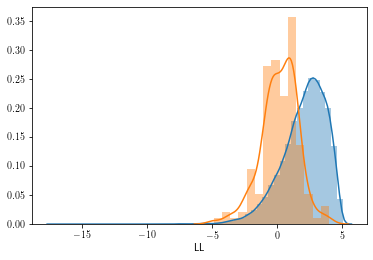

In [74]:
sns.distplot(df_iwae[df_iwae.label<0.5].LL)
sns.distplot(df_iwae[df_iwae.label>0.5].LL)

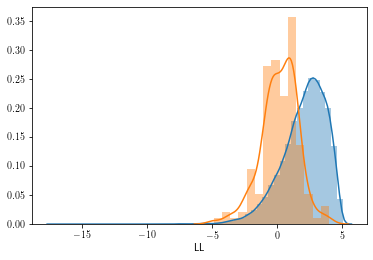

In [75]:
sns.distplot(df_iwae[df_iwae.label<0.5].LL)
sns.distplot(df_iwae[df_iwae.label>0.5].LL)

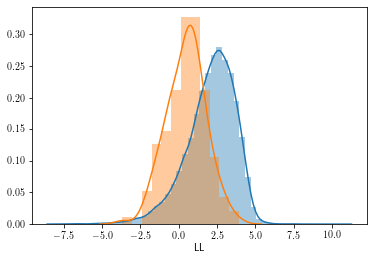

In [293]:
sns.distplot(df_sumo[df_sumo.label<0.5].LL)
sns.distplot(df_sumo[df_sumo.label>0.5].LL)

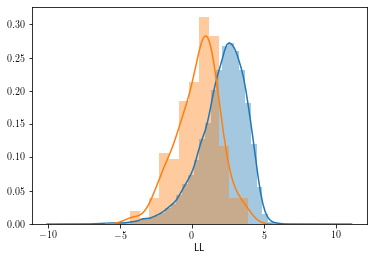

In [276]:
sns.distplot(df_sumo[df_sumo.label<0.5].LL)
sns.distplot(df_sumo[df_sumo.label>0.5].LL)

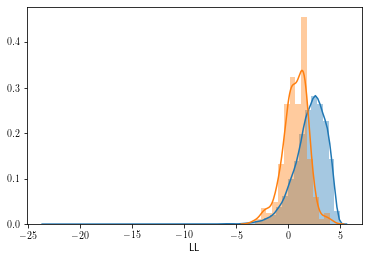

In [357]:
sns.distplot(df_sr_iwae[df_sr_iwae.label<0.5].LL)
sns.distplot(df_sr_iwae[df_sr_iwae.label>0.5].LL)

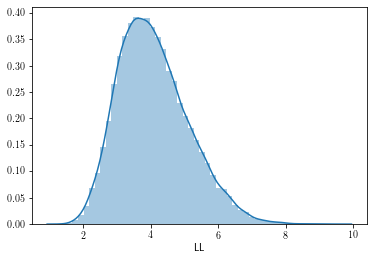

In [197]:
sns.distplot(df_sb_iwae.LL)

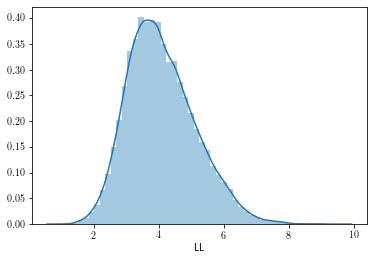

In [198]:
sns.distplot(df_sr_iwae.LL)

In [124]:
def postprocess(df_sr,df_sb,R_cutoff=5):
    print(df_sr.columns)
    auxillary = ['label'] + [col for col in df_sr.columns if col.startswith('_')]
    # R = np.exp(df_sr.LL - df_sb.LL)
    R = df_sr.LL - df_sb.LL
    lam = np.exp(df_sb.LL - df_sr.LL)
    Delta = df_sb.LL.mean() - df_sr.LL.mean()
    print('Delta', Delta)
    print('R max', R.max())
    print('R min', R.min())
    df_agg = pd.concat([df_sr[auxillary], R, df_sr.LL, df_sb.LL, lam], axis=1)#, columns=auxillary+['R','log_px_data',log_px_bkg'])
    df_agg.columns=auxillary+['R','log_px_data','log_px_bkg', 'lambda']
    df_agg.columns = [c.replace('_','-') for c in df_agg.columns]
    df_agg = df_agg[R<R_cutoff]
    print('Surviving after R<{} cut'.format(R_cutoff), df_agg.shape[0]/df_sr.shape[0])
    df_agg_sig, df_agg_bkg = df_agg[df_agg.label > 0.5], df_agg[df_agg.label < 0.5]
    
    roc_auc_i = roc_auc_score(df_agg.label, df_agg.R)
    print('AUROC using R', roc_auc_i)
    
    return df_agg, df_agg_sig, df_agg_bkg

In [76]:
df_agg_vae, df_agg_sig_vae, df_agg_bkg_vae = postprocess(df_sr=df_sr_vae, df_sb=df_sb_vae, R_cutoff=100)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 18.221450805664062
R min -43.82304763793945
Surviving after R<100 cut 1.0
AUROC using R 0.38907065250015005


In [82]:
df_agg_iwae, df_agg_sig_iwae, df_agg_bkg_iwae = postprocess(df_sr=df_sr_iwae, df_sb=df_sb_iwae, R_cutoff=100)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 4.994207382202148
R min -5.21600341796875
Surviving after R<100 cut 1.0
AUROC using R 0.8771238723261814


In [85]:
df_sb_iwaes_2048 = get_metrics('experiments/sb_t3*iwae_2048*/*.hdf')
df_sr_iwaes_2048 = get_metrics('experiments/sr_t3*iwae_2048*/*.hdf')
df_sr_iwae = pd.read_hdf(df_sr_iwaes_2048[-1])
df_sb_iwae = pd.read_hdf(df_sb_iwaes_2048[-1])

In [82]:
df_agg_iwae, df_agg_sig_iwae, df_agg_bkg_iwae = postprocess(df_sr=df_sr_iwae, df_sb=df_sb_iwae, R_cutoff=5)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 14.548450469970703
R min 0.01069430448114872
Surviving after R<5 cut 0.999498477521046
AUROC using R 0.9015175594672562


In [86]:
df_agg_iwae, df_agg_sig_iwae, df_agg_bkg_iwae = postprocess(df_sr=df_sr_iwae, df_sb=df_sb_iwae, R_cutoff=5)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 35.37173843383789
R min 0.004123170860111713
Surviving after R<5 cut 0.9993193623499911
AUROC using R 0.8972943354313218


In [83]:
df_agg_maf, df_agg_sig_maf, df_agg_bkg_maf = postprocess(df_sr=df_sr_maf, df_sb=df_sb_maf)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 18.456907272338867
R min 1.8535624424220742e-11
Surviving after R<5 cut 0.999785061794734
AUROC using R 0.8372162882231207


In [84]:
df_agg_nvp, df_agg_sig_nvp, df_agg_bkg_nvp = postprocess(df_sr=df_sr_nvp, df_sb=df_sb_nvp)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj', '__Mj1', '__Mj2'],
      dtype='object')
R max 3.5309605598449707
R min 0.06845715641975403
Surviving after R<5 cut 1.0
AUROC using R 0.846137103067411


In [ ]:
df_sr_ffjords = [pd.read_hdf(f) for f in ffjord_sr_fnames]
df_sb_ffjords = [pd.read_hdf(f) for f in ffjord_sb_fnames]

In [444]:
df_agg_ffjord, df_agg_sig_ffjord, df_agg_bkg_ffjord = postprocess(df_sr=df_sr_ffjords[0], df_sb=df_sb_ffjords[0], R_cutoff=5)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 12.406953811645508
R min 0.0978035107254982
Surviving after R<5 cut 0.999462654486835
AUROC using R 0.9162319519519521


In [115]:
df_agg_ffjord_bf, df_agg_sig_ffjord_bf, df_agg_bkg_ffjord_bf = postprocess(df_sr=df_sr_ffjord_bf, df_sb=df_sb_ffjord_bf, R_cutoff=15)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 11.865224838256836
R min 0.001648023840971291
Surviving after R<15 cut 1.0
AUROC using R 0.8961355423494808


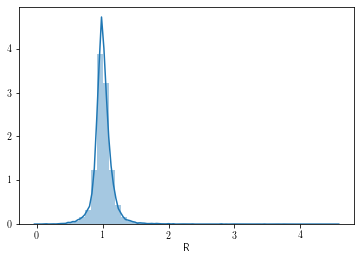

In [268]:
sns.distplot(df_agg_maf.R)

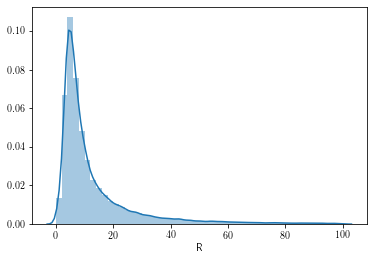

In [318]:
sns.distplot(df_agg_vae.R)

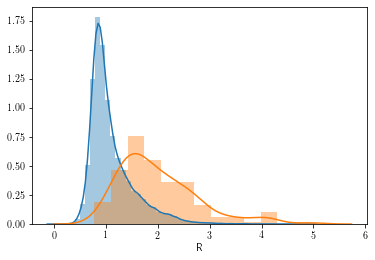

In [359]:
sns.distplot(df_agg_iwae[df_agg_iwae.label<0.5].R)
sns.distplot(df_agg_iwae[df_agg_iwae.label>0.5].R)

In [16]:
def compare_sb(df_sig, df_bkg, var, logscale=False, kde=True):
    sns.distplot(df_sig[var], label='sig', kde=kde)
    sns.distplot(df_bkg[var], label='bkg', kde=kde)
    plt.legend()
    if logscale is True:
        plt.yscale('log')
    plt.show()

In [200]:
def lambda_v_logpx(x, y, x_sig, y_sig, fname='lambda_v_logpx_bkg.pdf', lims=((-2,5),(0,4))):
    xlim, ylilm = lims
    xmin, xmax = xlim
    ymin, ymax = ylilm
    fs = 16
    # xmin, xmax, ymin, ymax = -5,5,-5.,5

    plt.figure(figsize=(10,6))
    plt.tick_params(axis='both', which='major', labelsize=15)
    # plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.hexbin(x,y,gridsize=((60,60)), extent=(xmin,xmax, ymin,ymax), cmap='viridis')#, label='Background')
    # plt.hist2d(x,y,bins=((60,60)), range=((xmin,xmax),(ymin,ymax)),cmap='viridis')
    cb=plt.colorbar()
    cb.set_label(r'$N$', fontsize=fs)
    cb.ax.tick_params(labelsize=15)

    #create legend
    line1 = Line2D(range(1), range(1), color="white", marker='.', markersize=16, markerfacecolor="red", linestyle='none')
    line4 = Line2D(range(1), range(1), color="white", marker='H',markersize=12,markerfacecolor="tab:green", linestyle='none')
    plt.legend((line1,line4),('Signal', 'Background'), numpoints=1, loc=2, fontsize=14)

    color = 'red'
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.scatter(x_sig,y_sig, marker='.', c=color, label='Signal', alpha=0.8)
    # plt.legend(fontsize=18)

    plt.xlabel(r'$\log p(\mathbf{x} \vert \textsf{bkg})$', fontsize=20)
    # plt.ylabel(r'$\log p(\mathbf{x} \vert \textsf{data})$', fontsize=20)
    plt.ylabel(r'$\lambda(\mathbf{x})^{-1}$', fontsize=20)
    plt.savefig(os.path.join('imgs',fname), bbox_inches='tight', format='pdf', dpi=128)

In [115]:
df_agg_bkg.columns

Index(['label', '-Mjj', '-Mj1-OG', '-Mj2-OG', '-deltaM-OG', '-j1-tau21-OG',
       '-j2-tau21-OG', '--label', '--Mjj', 'R', 'log-px-data', 'log-px-bkg'],
      dtype='object')

In [202]:
df_double_iw128_data = pd.read_hdf(glob.glob('experiments/iwae_double_008_128_jets_no_flow_2020_07_10_19_38/*.hdf')[0])
df_double_iw128_bkg = pd.read_hdf(glob.glob('experiments/iwae_double_008_128_jets_no_flow_2020_07_10_19_38/*.hdf')[-1])
df_double_iw128_data = pd.read_hdf('experiments/s_jets_no_flow_2020_07_11_11_57/flow_metrics_s_jets_no_flow_2020_07_11_11_57_________________data_all.hdf')
df_double_iw128_bkg = pd.read_hdf('experiments/s_jets_no_flow_2020_07_11_11_57/flow_metrics_s_jets_no_flow_2020_07_11_11_57_________________data_bkg_all.hdf')
df_agg, df_agg_sig, df_agg_bkg = postprocess(df_double_iw128_data, df_double_iw128_bkg, 100)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 17.29413414001465
R min -46.95302963256836
Surviving after R<100 cut 1.0
AUROC using R 0.857099563855643


In [192]:
df_agg_sig.columns

Index(['label', '-Mjj', '-Mj1-OG', '-Mj2-OG', '-deltaM-OG', '-j1-tau21-OG',
       '-j2-tau21-OG', '--label', '--Mjj', 'R', 'log-px-data', 'log-px-bkg',
       'lam'],
      dtype='object')

AUROC using R 0.857 +/- 0.000
Sig R 0.094 +/- 0.000
Bkg R 0.674 +/- 0.000
Delta R 0.580 +/- 0.000


(array([0.5798006]), array([0.85709956]))

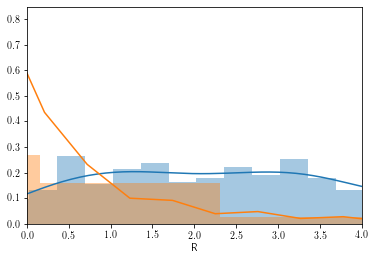

In [219]:
all_eval2([df_agg])

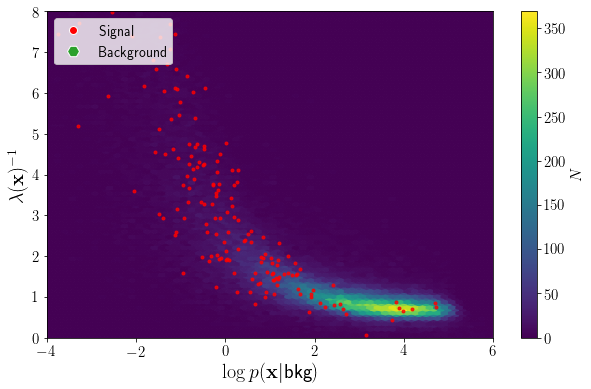

In [210]:
x = df_agg_bkg['log-px-bkg']
y = np.exp(df_agg_bkg.R)
x_sig = df_agg_sig['log-px-bkg']
y_sig = np.exp(df_agg_sig.R)
lambda_v_logpx(x,y,x_sig,y_sig, fname='logpx_bkg_v_data.pdf', lims=((-4,6),(0,8)))

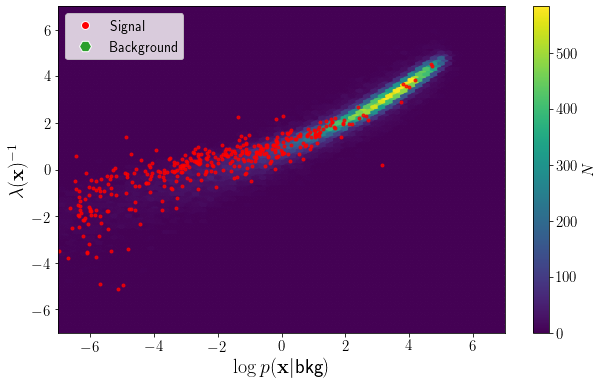

In [214]:
x = df_agg_bkg['log-px-bkg']
y = df_agg_bkg['log-px-data']
x_sig = df_agg_sig['log-px-bkg']
y_sig = df_agg_sig['log-px-data']
lambda_v_logpx(x,y,x_sig,y_sig, fname='logpx_bkg_v_data.pdf', lims=((-7,7),(-7,7)))

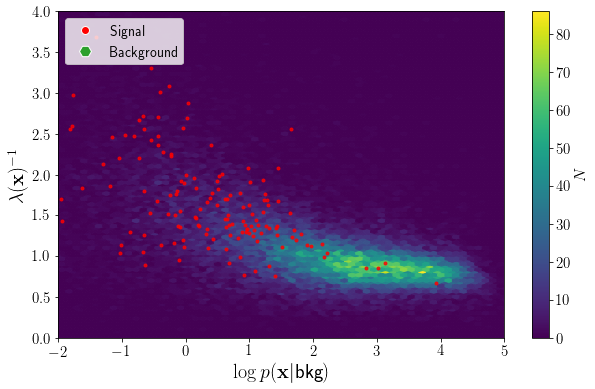

In [105]:
x = df_agg_bkg_sumo['log-px-bkg']
y = df_agg_bkg_sumo.R
x_sig = df_agg_sig_sumo['log-px-bkg']
y_sig = df_agg_sig_sumo.R
lambda_v_logpx(x,y,x_sig,y_sig, fname='lambda_v_logpx_bkg_sumo.pdf')

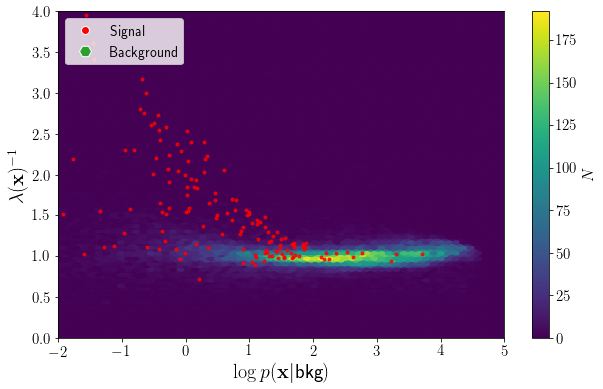

In [60]:
x = df_agg_bkg_maf['log-px-bkg']
y = df_agg_bkg_maf.R
x_sig = df_agg_sig_maf['log-px-bkg']
y_sig = df_agg_sig_maf.R
lambda_v_logpx(x,y,x_sig,y_sig, fname='lambda_v_logpx_bkg_test.pdf')

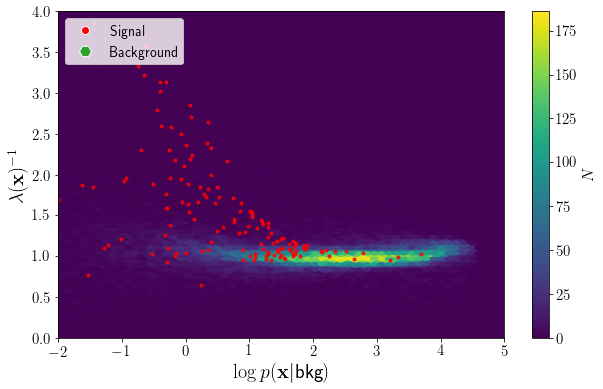

In [137]:
x = df_agg_bkg_maf['log-px-bkg']
y = df_agg_bkg_maf.R
x_sig = df_agg_sig_maf['log-px-bkg']
y_sig = df_agg_sig_maf.R
lambda_v_logpx(x,y,x_sig,y_sig, fname='lambda_v_logpx_bkg_test.pdf')

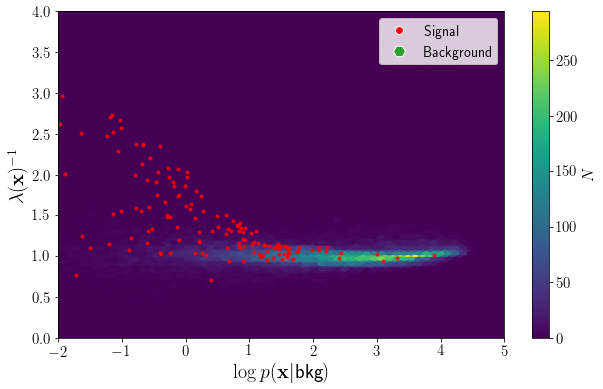

In [370]:
x = df_agg_bkg_nvp['log-px-bkg']
y = df_agg_bkg_nvp.R
x_sig = df_agg_sig_nvp['log-px-bkg']
y_sig = df_agg_sig_nvp.R
lambda_v_logpx(x,y,x_sig,y_sig, fname='lambda_v_logpx_bkg_NVP.pdf')

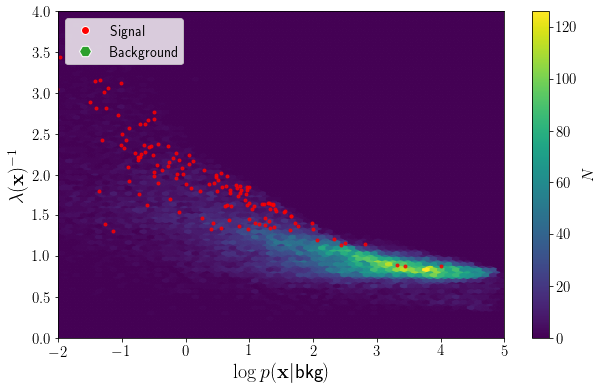

In [431]:
x = df_agg_bkg_ffjord['log-px-bkg']
y = df_agg_bkg_ffjord.R
x_sig = df_agg_sig_ffjord['log-px-bkg']
y_sig = df_agg_sig_ffjord.R
lambda_v_logpx(x,y,x_sig,y_sig, fname='lambda_v_logpx_bkg_FFJORD.pdf')

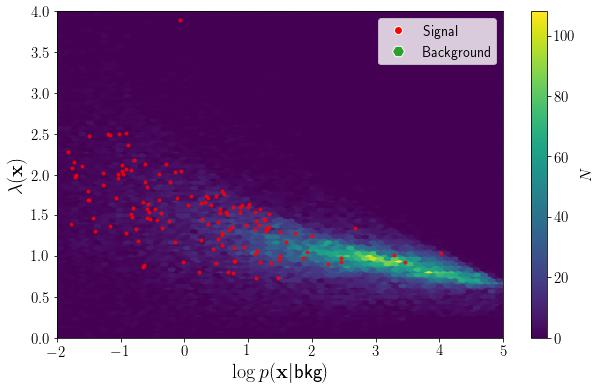

In [217]:
x = df_agg_bkg_ffjord['log-px-bkg']
y = df_agg_bkg_ffjord.R
x_sig = df_agg_sig_ffjord['log-px-bkg']
y_sig = df_agg_sig_ffjord.R
lambda_v_logpx(x,y,x_sig,y_sig, fname='lambda_v_logpx_bkg_FFJORD.pdf')

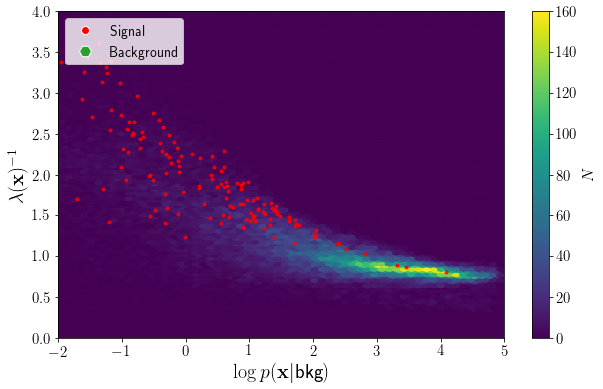

In [116]:
x = df_agg_bkg_ffjord_bf['log-px-bkg']
y = df_agg_bkg_ffjord_bf.R
x_sig = df_agg_sig_ffjord_bf['log-px-bkg']
y_sig = df_agg_sig_ffjord_bf.R
lambda_v_logpx(x,y,x_sig,y_sig, fname='lambda_v_logpx_bkg_FFJORD.pdf')

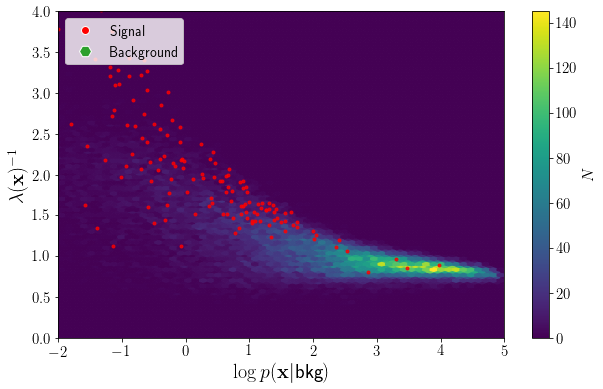

In [64]:
x = df_agg_bkg_iwae['log-px-bkg']
y = df_agg_bkg_iwae.R
x_sig = df_agg_sig_iwae['log-px-bkg']
y_sig = df_agg_sig_iwae.R
lambda_v_logpx(x,y,x_sig,y_sig, fname='lambda_v_logpx_bkg_iwae.pdf')

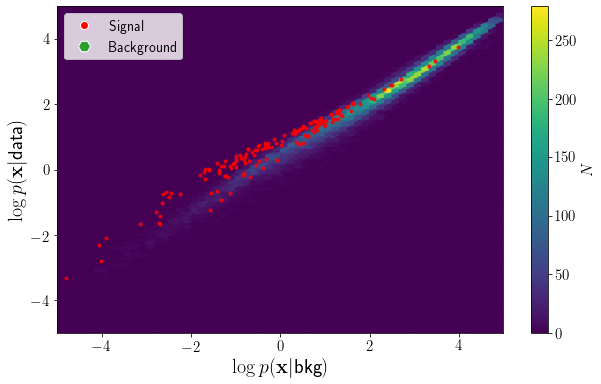

In [392]:
x = df_agg_bkg_ffjord['log-px-bkg']
y = df_agg_bkg_ffjord['log-px-data']
x_sig = df_agg_sig_ffjord['log-px-bkg']
y_sig = df_agg_sig_ffjord['log-px-data']
lambda_v_logpx(x,y,x_sig,y_sig, fname='logpx_bkg_v_data_FFJORD.pdf')

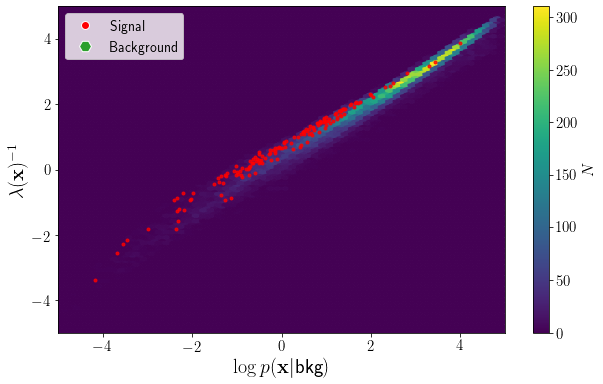

In [446]:
x = df_agg_bkg_ffjord['log-px-bkg']
y = df_agg_bkg_ffjord['log-px-data']
x_sig = df_agg_sig_ffjord['log-px-bkg']
y_sig = df_agg_sig_ffjord['log-px-data']
lambda_v_logpx(x,y,x_sig,y_sig, fname='logpx_bkg_v_data_FFJORD.pdf', lims=((-5,5),(-5,5)))

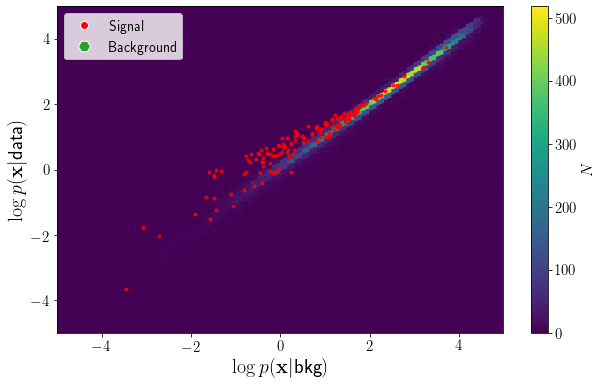

In [393]:
x = df_agg_bkg_maf['log-px-bkg']
y = df_agg_bkg_maf['log-px-data']
x_sig = df_agg_sig_maf['log-px-bkg']
y_sig = df_agg_sig_maf['log-px-data']
lambda_v_logpx(x,y,x_sig,y_sig, fname='logpx_bkg_v_data_MAF.pdf')

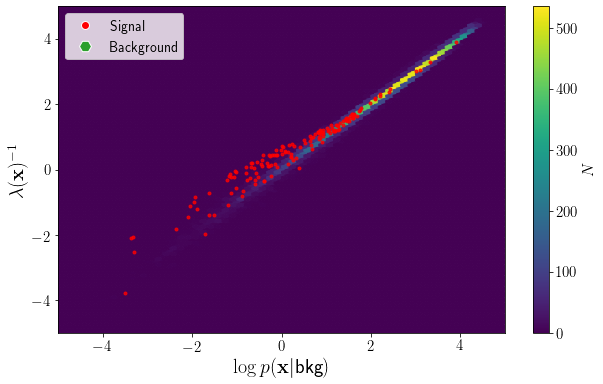

In [87]:
x = df_agg_bkg_nvp['log-px-bkg']
y = df_agg_bkg_nvp['log-px-data']
x_sig = df_agg_sig_nvp['log-px-bkg']
y_sig = df_agg_sig_nvp['log-px-data']
lambda_v_logpx(x,y,x_sig,y_sig, fname='logpx_bkg_v_data_NVP.pdf', lims=((-5,5),(-5,5)))

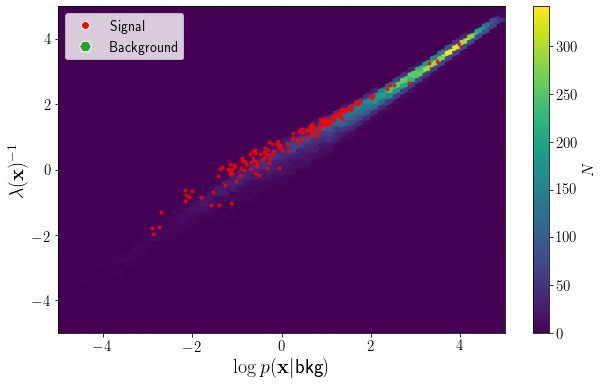

In [88]:
x = df_agg_bkg_iwae['log-px-bkg']
y = df_agg_bkg_iwae['log-px-data']
x_sig = df_agg_sig_iwae['log-px-bkg']
y_sig = df_agg_sig_iwae['log-px-data']
lambda_v_logpx(x,y,x_sig,y_sig, fname='logpx_bkg_v_data_IWAE.pdf', lims=((-5,5),(-5,5)))

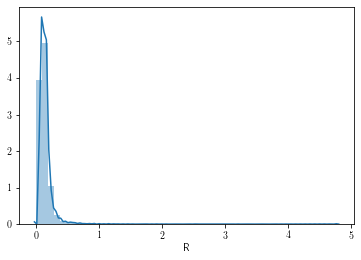

In [282]:
sns.distplot(df_agg_bkg_vae.R)

In [18]:
def compare_distributions(bkg, sig, logscale=False, fname='generic_compare.pdf'):   
    plt.figure(figsize=(10,6))
    plt.tick_params(axis='both', which='major', labelsize=16)
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    crimson_tide = '#e50005'
    yellow = 'xkcd:crimson'
    orange = '#ffa500'
    nbins=32
    sns.distplot(bkg, color=steel_blue,hist=True, kde=False, label='Background', bins=nbins, hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha=0.65))
    sns.distplot(sig, color=sea_green,hist=True, kde=False, label='Signal', bins=nbins, hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha=0.65))
    
    if logscale is True:
        plt.yscale('log')
    plt.legend(fontsize=14)
    plt.xlabel(r'$\lambda(\mathbf{x})$', fontsize=20)
    plt.ylabel(r'Counts', fontsize=20)
    # plt.savefig(os.path.join('imgs',fname), bbox_inches='tight', format='pdf', dpi=128)

In [399]:
df_agg_bkg_maf.columns

Index(['label', '-Mjj', '-Mj1-OG', '-Mj2-OG', '-deltaM-OG', '-j1-tau21-OG',
       '-j2-tau21-OG', '--label', '--Mjj', '--Mj1', '--Mj2', 'R',
       'log-px-data', 'log-px-bkg'],
      dtype='object')

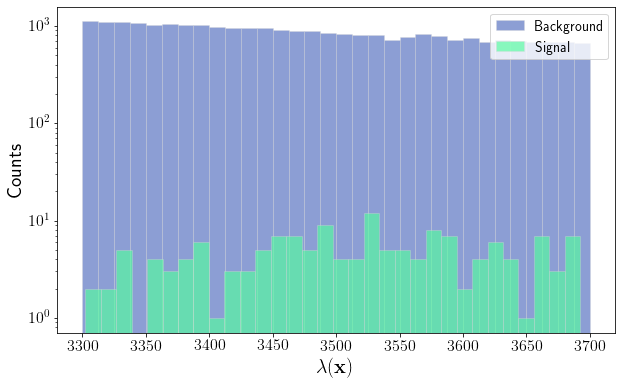

In [400]:
compare_distributions(bkg=df_agg_bkg_maf['-Mjj'], sig=df_agg_sig_maf['-Mjj'], logscale=True)

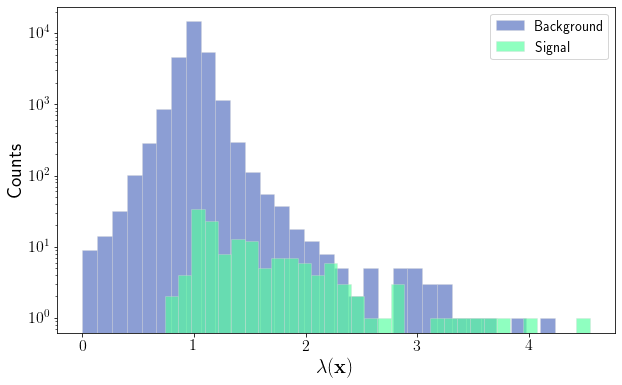

In [172]:
compare_distributions(bkg=df_agg_bkg_maf.R, sig=df_agg_sig_maf.R, logscale=True)

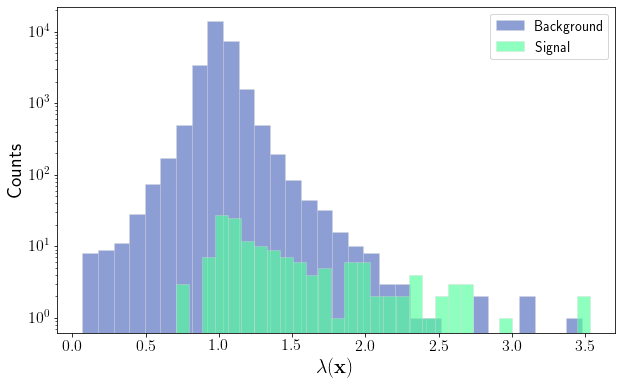

In [173]:
compare_distributions(bkg=df_agg_bkg_nvp.R, sig=df_agg_sig_nvp.R, logscale=True)

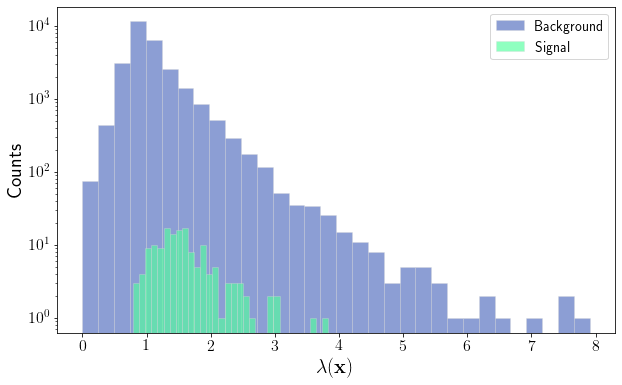

In [235]:
compare_distributions(bkg=df_agg_bkg_ffjord.R, sig=df_agg_sig_ffjord.R, logscale=True)

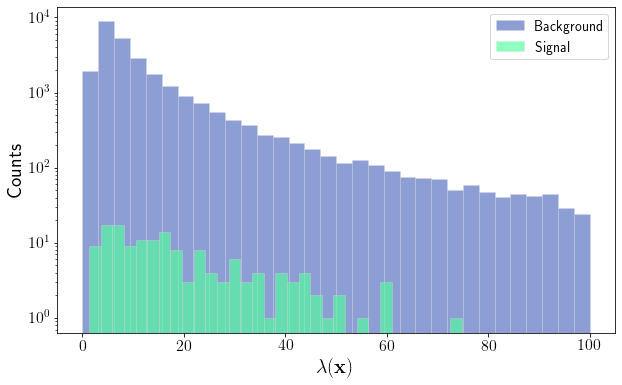

In [330]:
compare_distributions(bkg=df_agg_bkg_vae.R, sig=df_agg_sig_vae.R, logscale=True)

In [143]:
def plot_eff_multiple_nested(nested_dfs, labels, title='born2run', save_path='eff_comp.pdf', upper_y=1e5):

    def _boundaries(arrays):
        sizes = [a.shape[0] for a in arrays]
        a_primary = arrays[np.argmax(sizes)]
        a_min = np.empty(a_primary.shape[0])
        a_max = np.empty(a_primary.shape[0])

        for i in range(a_primary.shape[0]):

            try:
                elemwise = [a[i] for a in arrays]
                max_element = max(elemwise)
                min_element = min(elemwise)
                a_min[i] = min_element
                a_max[i] = max_element

            except IndexError:
                a_min[i] = a_primary[i]
                a_max[i] = a_primary[i]

        return a_min, a_max
    
    def _averaging(arrays):
        sizes = [a.shape[0] for a in arrays]
        a_primary = arrays[np.argmax(sizes)]
        a_avg = np.empty(a_primary.shape[0])
        a_std = np.empty(a_primary.shape[0])


        for i in range(a_primary.shape[0]):

            try:
                mean = np.mean([a[i] for a in arrays])
                std = np.std([a[i] for a in arrays])
                a_avg[i] = mean
                a_std[i] = std

            except IndexError:
                a_avg[i] = a_primary[i]
                a_std[i] = 0.0

        return a_avg, a_std
    

    # plt.figure()
    plt.figure(figsize=(10,6))
    plt.tick_params(axis='both', which='major', labelsize=16)

#    plt.axes([.1,.1,.8,.78])
#     plt.figtext(.5,.9, title, fontsize=22, ha='center')
#     plt.figtext(.5,.85, r'$b \rightarrow s \gamma$, Decorrelation comparison', fontsize=18,ha='center')
#    plt.figtext(.5,.9, r'$b \rightarrow s \gamma$, Decorrelation comparison', fontsize=18,ha='center')
    
    xcolors = ["denim blue", "medium green","pale red"]
    # palette = itertools.cycle(sns.xkcd_palette())
    # palette = itertools.cycle(sns.cubehelix_palette(8, start=.5, rot=-.75))
    # palette = itertools.cycle(sns.color_palette("hls", 8))
    palette = itertools.cycle(sns.color_palette())

    for (dfs, label) in zip(nested_dfs, labels):
        if not isinstance(dfs, list):
            dfs = [dfs]

        bkg_rej_all, sig_eff_all = list(), list()
        roc_auc_all = list()

        for df in dfs:
            fpr_i, tpr_i, thresholds = roc_curve(df.label, df.R)
            roc_auc_i = roc_auc_score(df.label, df.R)
            # fpr, tpr, thresholds = roc_curve(df['y_true'], df['y_prob'])
            # roc_auc = roc_auc_score(df.y_true, df.y_prob)

            # plt.plot(fpr_i, tpr_i, lw=1.8, label='{} (area = {:.4f})'.format('dummy',roc_auc_i))

            bkg_rej_all.append(1/(fpr_i + 1e-10))
            sig_eff_all.append(tpr_i)
            roc_auc_all.append(roc_auc_i)

        roc_auc_mean = np.mean(roc_auc_all)
        roc_auc_std = np.std(roc_auc_all)

        br_avg, br_std = _averaging(bkg_rej_all)
        se_avg, se_std = _averaging(sig_eff_all)
        
        color = next(palette)
        plt.plot(se_avg, br_avg, lw=1.8, label='{} (AUC = {:.3f} $\pm$ {:.3f})'.format(label, roc_auc_mean, roc_auc_std), color=color)
        plt.fill_between(se_avg, br_avg-br_std, br_avg+br_std, interpolate=True, alpha=0.25, color=color)
        
    plt.xlim([0.05, 1.0])
    plt.ylim([1.0, upper_y])
    delta = 0.1
    plt.xticks(np.arange(0.1, 1.+delta, delta))
    
    plt.yscale('log', nonposy='clip')
    plt.xlabel('Signal Efficiency', fontsize=20)
    plt.ylabel('Background Rejection', fontsize=20)
    plt.legend(loc="best", fontsize=16)
    
    plt.savefig(os.path.join('imgs', save_path), format='pdf', dpi=64, bbox_inches='tight')

In [22]:
df_agg_mafs = []
for (df_sr, df_sb) in zip([df_sr_maf, df_sr_maf1, df_sr_maf2],[df_sb_maf, df_sb_maf1, df_sb_maf2]):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb)
    df_agg_mafs.append(df_agg)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 18.456907272338867
R min 1.8535624424220742e-11
Surviving after R<5 cut 0.999785061794734
AUROC using R 0.8372162882231207
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet

In [23]:
df_agg_nvps = []
for (df_sr, df_sb) in zip([df_sr_nvp, df_sr_nvp1, df_sr_nvp2],[df_sb_nvp, df_sb_nvp1, df_sb_nvp2]):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb)
    df_agg_nvps.append(df_agg)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj', '__Mj1', '__Mj2'],
      dtype='object')
R max 3.5309605598449707
R min 0.06845715641975403
Surviving after R<5 cut 1.0
AUROC using R 0.846137103067411
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet

In [24]:
df_agg_ffjords = []
for (df_sr, df_sb) in zip([df_sr_ffjord, df_sr_ffjord1, df_sr_ffjord2],[df_sb_ffjord, df_sb_ffjord1,df_sb_ffjord2]):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb)
    df_agg_ffjords.append(df_agg)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj', '__Mj1', '__Mj2'],
      dtype='object')
R max 55.18628692626953
R min 0.013017680495977402
Surviving after R<5 cut 0.9987820168368261
AUROC using R 0.9071783444642494
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px',

In [26]:
ffjord_sb_fnames = glob.glob('experiments/cnf_approx_2b_tanh_jets_sb*/*.hdf')
ffjord_sr_fnames = glob.glob('experiments/cnf_approx_2b_tanh_jets_sr*/*.hdf')

In [28]:
df_sr_ffjords = [pd.read_hdf(f) for f in ffjord_sr_fnames]
df_sb_ffjords = [pd.read_hdf(f) for f in ffjord_sb_fnames]

In [29]:
df_agg_ffjords_new = []
for (df_sr, df_sb) in zip(df_sr_ffjords, df_sb_ffjords):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb, R_cutoff=5)
    df_agg_ffjords_new.append(df_agg)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 10.094307899475098
R min 0.0490594319999218
Surviving after R<5 cut 0.999785061794734
AUROC using R 0.9202202288747193
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz

In [30]:
df_agg_ffjords_new.pop(-2)

,label,-Mjj,-Mj1-OG,-Mj2-OG,-deltaM-OG,-j1-tau21-OG,-j2-tau21-OG,--label,--Mjj,--Mj1,--Mj2,R,log-px-data,log-px-bkg
0,0.0,3567.517395,621.844350,94.046164,527.798186,0.221691,0.403653,0.0,3567.517334,621.844360,94.046165,2.370166,0.974722,0.111763
1,0.0,3411.597093,403.966840,80.934067,323.032773,0.544405,0.401811,0.0,3411.597168,403.966827,80.934067,1.370689,1.698788,1.383474
2,0.0,3497.658827,697.681233,417.283602,280.397632,0.203407,0.309351,0.0,3497.658936,697.681213,417.283600,2.448110,-0.499808,-1.395124
3,0.0,3325.972796,144.128113,74.026363,70.101750,0.607117,0.715127,0.0,3325.972900,144.128113,74.026367,0.782155,4.372655,4.618357
4,0.0,3404.988094,146.000321,133.208776,12.791545,0.615279,0.584745,0.0,3404.988037,146.000320,133.208771,0.752162,4.066614,4.351417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27910,0.0,3427.549953,393.533567,57.829031,335.704536,0.463926,0.743106,0.0,3427.550049,393.533569,57.829029,0.939802,2.360230,2.422317
27911,0.0,3301.449217,182.355985,69.036320,113.319665,0.768120,0.191962,0.0,3301.449219,182.355988,69.036316,1.131639,1.115825,0.992158
27912,0.0,3598.480679,894.943105,138.476097,756.467008,0.238391,0.504732,0.0,3598.480713,894.943115,138.476089,1.163921,-1.927105,-2.078900
27913,0.0,3589.429483,167.073030,129.250035,37.822995,0.801628,0.638300,0.0,3589.429443,167.073029,129.250031,0.862005,3.060910,3.209404


In [1]:
sumo_sr_fnames = get_metrics('experiments/*iwae_64_st*/*_all*.hdf')
sumo_sb_fnames = get_metrics('experiments/*iwae_64_gaussian*/*_all*.hdf')

df_st = [pd.read_hdf(f) for f in sumo_sr_fnames]
df_g = [pd.read_hdf(f) for f in sumo_sb_fnames]

NameError: name 'get_metrics' is not defined

In [264]:
sumo_sr_fnames = get_metrics('experiments/sumo_DOUBLE*12*/*data_all*.hdf')
sumo_sb_fnames = get_metrics('experiments/sumo_DOUBLE*12*/*bkg*.hdf')

df_sr_sumos = [pd.read_hdf(f) for f in sumo_sr_fnames]

df_sb_sumos = [pd.read_hdf(f) for f in sumo_sb_fnames]

In [346]:
cnf_sr_fnames = get_metrics('experiments/cnf_jets_cnf_2020_07_11_21_3*/*data_all*.hdf')
cnf_sb_fnames = get_metrics('experiments/cnf_jets_cnf_2020_07_11_21_3*/*bkg*.hdf')

df_sr_cnfs = [pd.read_hdf(f) for f in cnf_sr_fnames]

df_sb_cnfs = [pd.read_hdf(f) for f in cnf_sb_fnames]

In [314]:
nvp_sr_fnames = get_metrics('experiments/nvp_STUDENT*/*data_all*.hdf')
nvp_sb_fnames = get_metrics('experiments/nvp_STUDENT*/*bkg*.hdf')

df_sr_nvps = [pd.read_hdf(f) for f in nvp_sr_fnames]

df_sb_nvps = [pd.read_hdf(f) for f in nvp_sb_fnames]

In [265]:
maf_sr_fnames = get_metrics('experiments/maf_STUDENT*/*data_all*.hdf')
maf_sb_fnames = get_metrics('experiments/maf_STUDENT*/*bkg*.hdf')

df_sr_mafs = [pd.read_hdf(f) for f in maf_sr_fnames]

df_sb_mafs = [pd.read_hdf(f) for f in maf_sb_fnames]

In [181]:
g = df_agg_iwae1024s[0]

In [185]:
df_agg_bkg_iwae = g[g.label < 0.5]

df_agg_sig_iwae = g[g.label > 0.5]

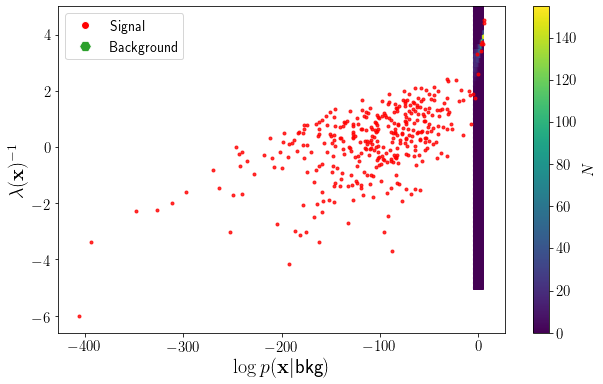

In [186]:
x = df_agg_bkg_iwae['log-px-bkg']
y = df_agg_bkg_iwae['log-px-data']
x_sig = df_agg_sig_iwae['log-px-bkg']
y_sig = df_agg_sig_iwae['log-px-data']
lambda_v_logpx(x,y,x_sig,y_sig, fname='logpx_bkg_v_data_IWAE.pdf', lims=((-5,5),(-5,5)))

In [166]:
iwae16_sr_fnames = get_metrics('experiments/iwae_DOUBLE_16*/*data_all*.hdf')
iwae16_sb_fnames = get_metrics('experiments/iwae_DOUBLE_16*/*bkg*.hdf')

df_sr_iwae16s = [pd.read_hdf(f) for f in iwae16_sr_fnames]

df_sb_iwae16s = [pd.read_hdf(f) for f in iwae16_sb_fnames]

In [330]:
# iwae1024_sr_fnames = get_metrics('experiments/iwae_DOUBLE_256*/*data_all*.hdf')
# iwae1024_sb_fnames = get_metrics('experiments/iwae_DOUBLE_256*/*bkg*.hdf')

iwae1024_sr_fnames = get_metrics('experiments/iwae_double_64*16*/*data_all*.hdf')
iwae1024_sb_fnames = get_metrics('experiments/iwae_double_64*16*/*bkg*.hdf')

df_sr_iwae1024s = [pd.read_hdf(f) for f in iwae1024_sr_fnames]

df_sb_iwae1024s = [pd.read_hdf(f) for f in iwae1024_sb_fnames]

In [331]:
iwae1024_sb_fnames

['experiments/iwae_double_64_jets_no_flow_2020_07_11_16_00/flow_metrics_iwae_double_64_jets_no_flow_2020_07_11_16_00_________________data_bkg_all.hdf',
 'experiments/iwae_double_64_jets_no_flow_2020_07_11_16_06/flow_metrics_iwae_double_64_jets_no_flow_2020_07_11_16_06_________________data_bkg_all.hdf',
 'experiments/iwae_double_64_jets_no_flow_2020_07_11_16_11/flow_metrics_iwae_double_64_jets_no_flow_2020_07_11_16_11_________________data_bkg_all.hdf']

In [353]:
df_agg_cnfs = []
for (df_sr, df_sb) in zip(df_sr_cnfs,df_sb_cnfs):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb,R_cutoff=10)
    df_agg_cnfs.append(df_agg)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 10.265256881713867
R min -0.7165899276733398
Surviving after R<10 cut 0.9999850538807599
Surviving after R>-5 cut 0.9999850538807599
AUROC using R 0.8010311080221835
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',


/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [352]:
df_agg_iwae1024s = []
for (df_sr, df_sb) in zip(df_sr_iwae1024s,df_sb_iwae1024s):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb,R_cutoff=15)
    df_agg_iwae1024s.append(df_agg)

df_agg_iwae16s = []
for (df_sr, df_sb) in zip(df_sr_iwae16s,df_sb_iwae16s):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb,R_cutoff=10)
    df_agg_iwae16s.append(df_agg)

df_agg_sumos = []
for (df_sr, df_sb) in zip(df_sr_sumos, df_sb_sumos):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb, R_cutoff=15)
    df_agg_sumos.append(df_agg)

df_agg_nvps = []
for (df_sr, df_sb) in zip(df_sr_nvps,df_sb_nvps):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb,R_cutoff=15)
    df_agg_nvps.append(df_agg)

df_agg_mafs = []
for (df_sr, df_sb) in zip(df_sr_mafs,df_sb_mafs):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb,R_cutoff=15)
    df_agg_mafs.append(df_agg)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 36.9478874206543
R min -8.75137710571289
Surviving after R<15 cut 0.9997608620921578
Surviving after R>-5 cut 0.9997459159729176
AUROC using R 0.8682594966358306
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
    

/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  de

AUROC using R 0.6307943497776928
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 10.265256881713867
R min -0.7165899276733398
Surviving after R<15 cut 1.0
Surviving after R>-5 cut 1.0
AUROC using R 0.801019070044545
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi'

/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  de

Surviving after R>-5 cut 0.9937674682768619
AUROC using R 0.8312398396030016
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 26.895835876464844
R min -16.32723045349121
Surviving after R<15 cut 0.999461939707355
Surviving after R>-5 cut 0.9994320474688747
AUROC using R 0.8628224474570614
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
  

/home/jtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [354]:
def postprocess(df_sr,df_sb,R_cutoff=5, R_cutoff_low=-5):
    print(df_sr.columns)
    auxillary = ['label'] + [col for col in df_sr.columns if col.startswith('_')]
    lam = df_sb.LL - df_sr.LL
    R = df_sr.LL - df_sb.LL
    print('R max', R.max())
    print('R min', R.min())
    df_agg = pd.concat([df_sr[auxillary], R, df_sr.LL, df_sb.LL, lam], axis=1)#, columns=auxillary+['R','log_px_data',log_px_bkg'])
    df_agg.columns=auxillary+['R','log_px_data','log_px_bkg','lam']
    df_agg.columns = [c.replace('_','-') for c in df_agg.columns]
    df_agg = df_agg[R<R_cutoff]
    print('Surviving after R<{} cut'.format(R_cutoff), df_agg.shape[0]/df_sr.shape[0])
    df_agg = df_agg[R>R_cutoff_low]
    print('Surviving after R>{} cut'.format(R_cutoff_low), df_agg.shape[0]/df_sr.shape[0])

    df_agg_sig, df_agg_bkg = df_agg[df_agg.label > 0.5], df_agg[df_agg.label < 0.5]
    
    roc_auc_i = roc_auc_score(df_agg.label, df_agg.R)
    print('AUROC using R', roc_auc_i)
    
    return df_agg, df_agg_sig, df_agg_bkg

def all_eval2(dfs):
    EPS = 1e-3
    roc_aucs, sig_R, bkg_R, lam_sep = [], [], [], []
    for i,df in enumerate(dfs):
        # df['laambda'] = np.reciprocal(df.R+EPS)
        # df['laambda'] = np.reciprocal(df.R+EPS)
        avg_lam_sep = df.lam.mean()
        df_sig = df[df.label>0.5]
        df_bkg = df[df.label<0.5]
        if i == 0:
            sns.distplot(df_sig.R, bins=30)
            sns.distplot(df_bkg.R, bins=30)
            plt.xlim((0,10))
        roc_auc_i = roc_auc_score(df.label, df.R)
        roc_aucs.append(roc_auc_i)
        sig_R.append(np.exp(df_sig.lam).mean())
        bkg_R.append(np.exp(df_bkg.lam).mean())
        lam_sep.append((df['log-px-bkg'] - df['log-px-data']).mean())
        
    roc_aucs = np.array(roc_aucs)
    sig_R = np.array(sig_R)
    bkg_R = np.array(bkg_R)
    delta = bkg_R - sig_R
    lam_sep = np.array(lam_sep)
    print('AUROC using R {:.3f} +/- {:.3f}'.format(roc_aucs.mean(), roc_aucs.std()))
    print('Sig R {:.3f} +/- {:.3f}'.format(sig_R.mean(), sig_R.std()))
    print('Bkg R {:.3f} +/- {:.3f}'.format(bkg_R.mean(), bkg_R.std()))
    print('Delta R {:.3f} +/- {:.3f}'.format(delta.mean(), delta.std()))
    print('Delta Lambda {:.3f} +/- {:.3f}'.format(lam_sep.mean(), lam_sep.std()))

    return delta, roc_aucs


AUROC using R 0.852 +/- 0.002
Sig R 0.266 +/- 0.012
Bkg R 1.007 +/- 0.010
Delta R 0.741 +/- 0.005
Delta Lambda -0.492 +/- 0.055


(array([0.74685055, 0.74274373, 0.73461431]),
 array([0.85170534, 0.85408879, 0.84884398]))

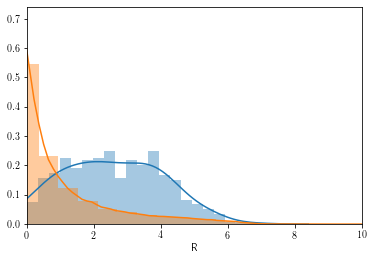

In [318]:
all_eval2(df_agg_sumos)

AUROC using R 0.869 +/- 0.015
Sig R 0.062 +/- 0.002
Bkg R 1.030 +/- 0.004
Delta R 0.968 +/- 0.005
Delta Lambda -2.071 +/- 0.280


(array([0.97385675, 0.96154603, 0.96957615]),
 array([0.86282245, 0.88877118, 0.85473715]))

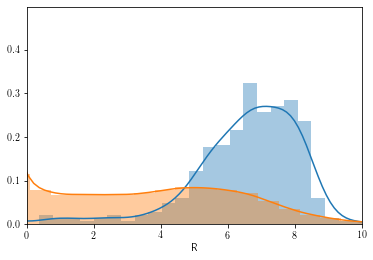

In [319]:
all_eval2(df_agg_mafs)

AUROC using R 0.832 +/- 0.002
Sig R 0.326 +/- 0.022
Bkg R 1.017 +/- 0.005
Delta R 0.691 +/- 0.026
Delta Lambda -1.025 +/- 0.063


(array([0.70818487, 0.71168   , 0.65402326]),
 array([0.83485672, 0.83130714, 0.83123984]))

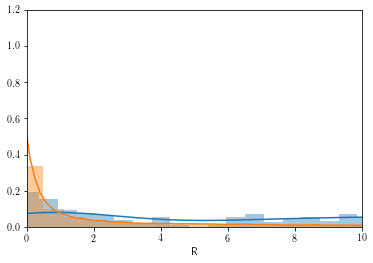

In [321]:
all_eval2(df_agg_nvps)

AUROC using R 0.871 +/- 0.005
Sig R 0.147 +/- 0.028
Bkg R 0.916 +/- 0.008
Delta R 0.769 +/- 0.021
Delta Lambda -0.786 +/- 0.127


(array([0.73966317, 0.78285953, 0.78450163]),
 array([0.8682595 , 0.87791262, 0.86779122]))

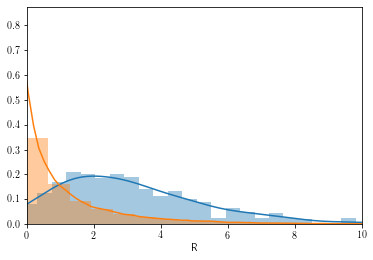

In [334]:
all_eval2(df_agg_iwae1024s)

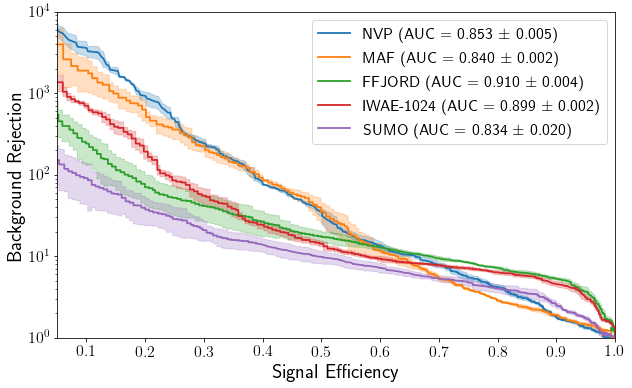

In [519]:
plot_eff_multiple_nested([df_agg_nvps, df_agg_mafs, df_agg_ffjords_new, df_agg_iwaes, df_agg_sumos], labels=['NVP','MAF', 'FFJORD', 'IWAE-1024', 'SUMO'],
                         upper_y=1e4, title='born2run', save_path='eff_comp.pdf')

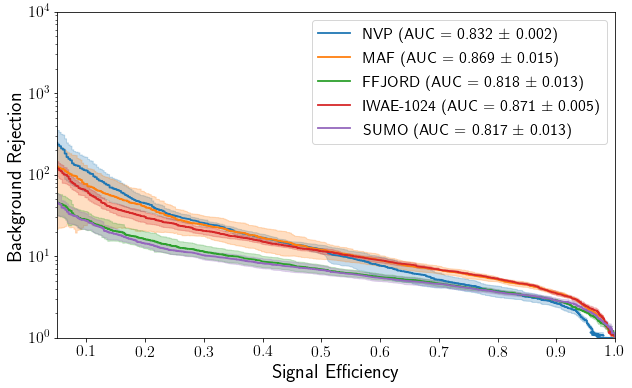

In [357]:
plot_eff_multiple_nested([df_agg_nvps, df_agg_mafs,df_agg_cnfs, df_agg_iwae1024s, df_agg_sumos], labels=['NVP','MAF', 'FFJORD','IWAE-1024','SUMO'],
                         upper_y=1e4, title='born2run', save_path='eff_comp_double.pdf')

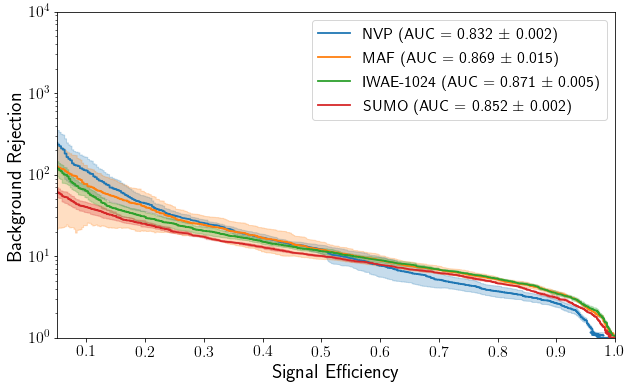

In [340]:
plot_eff_multiple_nested([df_agg_nvps, df_agg_mafs, df_agg_iwae1024s, df_agg_sumos], labels=['NVP','MAF', 'IWAE-1024', 'SUMO'],
                         upper_y=1e4, title='born2run', save_path='eff_comp_double.pdf')

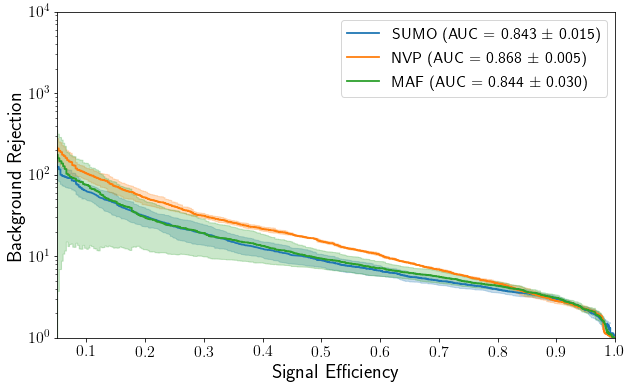

In [164]:
plot_eff_multiple_nested([df_agg_sumos, df_agg_nvps, df_agg_mafs], labels=['SUMO','NVP','MAF'], upper_y=1e4, save_path='eff_comp_j.pdf')

In [34]:
df_agg_sumos = []
for (df_sr, df_sb) in zip(df_sr_sumos, df_sb_sumos):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb, R_cutoff=50)
    df_agg_sumos.append(df_agg)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 165677.015625
R min 0.002011612756177783
Surviving after R<50 cut 0.9998567078631561
AUROC using R 0.8212218580022334
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz'

In [35]:
df_sb_iwaes_32 = get_metrics('experiments/sb_t3*iwae_32*/*.hdf')
df_sr_iwaes_32 = get_metrics('experiments/sr_t3*iwae_32*/*.hdf')
df_sb_iwaes_64 = get_metrics('experiments/sb_t3*iwae_64*/*.hdf')
df_sr_iwaes_64 = get_metrics('experiments/sr_t3*iwae_64*/*.hdf')
df_sb_iwaes_128 = get_metrics('experiments/sb_t3*iwae_128*/*.hdf')
df_sr_iwaes_128 = get_metrics('experiments/sr_t3*iwae_128*/*.hdf')
df_sb_iwaes_256 = get_metrics('experiments/sb_t3*iwae_256*/*.hdf')
df_sr_iwaes_256 = get_metrics('experiments/sr_t3*iwae_256*/*.hdf')
df_sb_iwaes_512 = get_metrics('experiments/sb_t3*iwae_512*/*.hdf')
df_sr_iwaes_512 = get_metrics('experiments/sr_t3*iwae_512*/*.hdf')
df_sb_iwaes_1024 = get_metrics('experiments/sb_t3*iwae_1024*/*.hdf')
df_sr_iwaes_1024 = get_metrics('experiments/sr_t3*iwae_1024*/*.hdf')
df_sb_iwaes_2048 = get_metrics('experiments/sb_t3*iwae_2048*/*.hdf')
df_sr_iwaes_2048 = get_metrics('experiments/sr_t3*iwae_2048*/*.hdf')

df_agg_iwaes_K = [[] for _ in range(7)]
for i,j in enumerate(range(5,12)):
    df_sr_iwaes = [pd.read_hdf(f) for f in eval('df_sr_iwaes_{}'.format(int(2**j)))]
    df_sb_iwaes = [pd.read_hdf(f) for f in eval('df_sb_iwaes_{}'.format(int(2**j)))]
    for (df_sr, df_sb) in zip(df_sr_iwaes,df_sb_iwaes):
        df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb, R_cutoff=5)
        df_agg_iwaes_K[i].append(df_agg)
df_agg_iwaes = df_agg_iwaes_K[-1]

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 37.813987731933594
R min 3.0899296689312905e-05
Surviving after R<5 cut 0.9988536629052481
AUROC using R 0.8714461322371927
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'je

In [36]:
df_sb_iwaes_2048

['experiments/sb_t32_iwae_2048_jets_no_flow_2020_07_06_07_21/flow_metrics_sb_t32_iwae_2048_jets_no_flow_2020_07_06_07_21_SB.hdf',
 'experiments/sb_t31_iwae_2048_jets_no_flow_2020_07_06_07_21/flow_metrics_sb_t31_iwae_2048_jets_no_flow_2020_07_06_07_21_SB.hdf',
 'experiments/sb_t30_iwae_2048_jets_no_flow_2020_07_06_13_35/flow_metrics_sb_t30_iwae_2048_jets_no_flow_2020_07_06_13_35_SB.hdf']

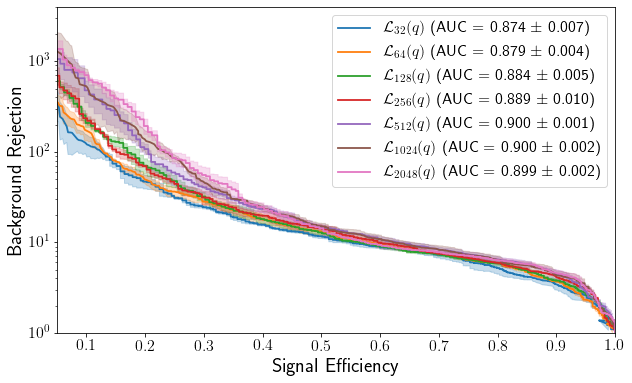

In [37]:
plot_eff_multiple_nested(df_agg_iwaes_K, labels=[r'$\mathcal{{L}}_{{{}}}(q)$'.format(2**i) for i in range(5,15)], upper_y=4e3, save_path='eff_comp_iwae.pdf')

In [508]:
df_sr_iwaes_t1 = [pd.read_hdf(fname) for fname in iwae_sr_fnames_t1]
df_sb_iwaes_t1 = [pd.read_hdf(fname) for fname in iwae_sb_fnames_t1]

In [509]:
df_agg_iwaes = []
for (df_sr, df_sb) in zip(df_sr_iwaes_t1,df_sb_iwaes_t1):
    df_agg, *_ = postprocess(df_sr=df_sr, df_sb=df_sb, R_cutoff=5)
    df_agg_iwaes.append(df_agg)

Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
       'jet2-py', 'jet2-pz', 'jet3-pt', 'jet3-eta', 'jet3-phi', 'jet3-m',
       'met-pt', 'met-phi', 'LL', '__label', '__Mjj'],
      dtype='object')
R max 37.813987731933594
R min 3.0899296689312905e-05
Surviving after R<5 cut 0.9988536629052481
Index(['label', '_Mjj', 'Mj1', 'j1-sqrt(tau21)/tau11', 'j1-tau21', 'j1-tau32',
       'j1-tau43', 'Mj2', 'j2-tau21', 'j2-tau32', 'j2-tau43', 'deltaM',
       '_Mj1-OG', '_Mj2-OG', '_deltaM-OG', '_j1-tau21-OG', '_j2-tau21-OG',
       'jet1-pt', 'jet1-eta', 'jet1-phi', 'jet2-pt', 'jet2-eta', 'jet2-phi',
       'jet1-E', 'jet1-px', 'jet1-py', 'jet1-pz', 'jet2-E', 'jet2-px',
    

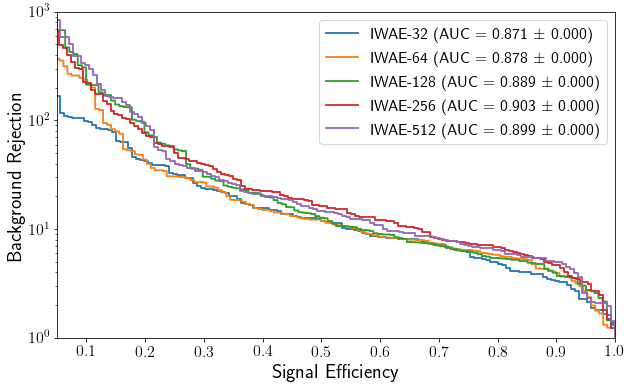

In [514]:
plot_eff_multiple_nested(df_agg_iwaes, labels=['IWAE-{}'.format(2**i) for i in range(5,12)], upper_y=1e3, save_path='eff_comp_iwae.pdf')

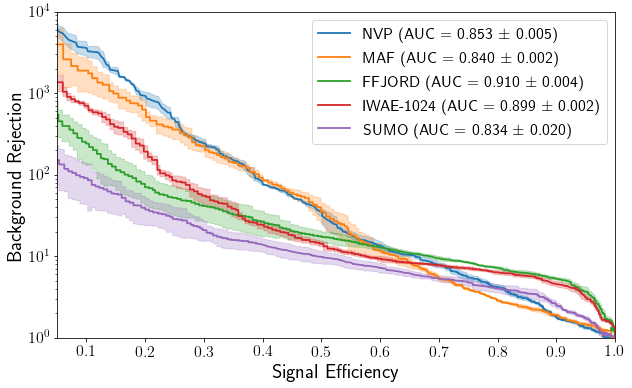

In [519]:
plot_eff_multiple_nested([df_agg_nvps, df_agg_mafs, df_agg_ffjords_new, df_agg_iwaes, df_agg_sumos], labels=['NVP','MAF', 'FFJORD', 'IWAE-1024', 'SUMO'],
                         upper_y=1e4, title='born2run', save_path='eff_comp.pdf')

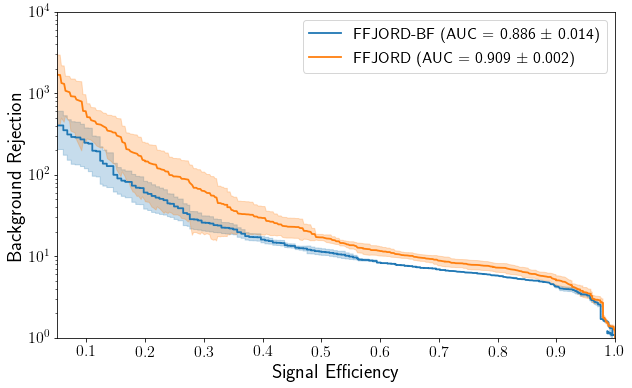

In [122]:
plot_eff_multiple_nested([df_agg_ffjord_bfs, df_agg_ffjords], labels=['FFJORD-BF', 'FFJORD'], 
                          upper_y=1e4, title='born2run', save_path='test.pdf')

In [ ]:
compare_sb(df_sig, df_bkg, 'j1-tau21')

In [ ]:
compare_sb(df_sig, df_bkg, 'j2-tau21')

In [ ]:
compare_sb(df_sig, df_bkg, 'Mj1', logscale=True, kde=False)

In [ ]:
compare_sb(df_sig, df_bkg, 'Mj2', logscale=True, kde=False)

In [ ]:
compare_sb(df_sig, df_bkg, 'deltaM', logscale=True, kde=False)

In [ ]:
compare_sb(df_sig, df_bkg, 'Mjj', logscale=True, kde=False)

In [ ]:
compare_sb(df_sig, df_bkg, 'jet1-pt', logscale=True, kde=False)

In [ ]:
# Subsample signal events 
N_SIG = 10000
df_sig = df_sig.sample(n=N_SIG)
df = pd.concat([df_sig, df_bkg]).sample(frac=1).reset_index(drop=True)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_test, df_val = train_test_split(df_test, test_size=0.25)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
df_train.to_hdf('jets_all_train.h5', key='df')
df_test.to_hdf('jets_all_test.h5', key='df')
df_val.to_hdf('jets_all_val.h5', key='df')

In [ ]:
logit_transform = True

In [ ]:
def scale_dataset(df, scaler=None, logit_transform=False):

    df_protected = df[['label', 'Mjj']+[col for col in df.columns if 'OG' in col]]
    df_unprotected = df.drop(df_protected.columns, axis=1)

    if logit_transform is True:
        EPS = 0.01
        if scaler is None:
            scaler = MinMaxScaler((0+EPS,1-EPS))
            df_unprotected = pd.DataFrame(logit(scaler.fit_transform(df_unprotected)), columns=df_unprotected.columns)
        else:
            df_unprotected = pd.DataFrame(logit(scaler.transform(df_unprotected)), columns=df_unprotected.columns)
    else:
        if scaler is None:
            scaler = MinMaxScaler((-1,1))
            df_unprotected = pd.DataFrame(scaler.fit_transform(df_unprotected), columns=df_unprotected.columns)
        else:
            df_unprotected = pd.DataFrame(scaler.transform(df_unprotected), columns=df_unprotected.columns)

    df_scaled = pd.concat([df_protected, df_unprotected], axis=1)
    df_scaled = df_scaled.dropna()
    
    return df_scaled, scaler

In [ ]:
df_train_scaled, scaler = scale_dataset(df_train, logit_transform=True)

In [ ]:
df_test_scaled, scaler = scale_dataset(df_test, scaler=scaler, logit_transform=True)

In [ ]:
df_test_scaled.head()

In [ ]:
df_train_scaled.to_hdf('jets_medium_logit_train.h5', key='df')
df_test_scaled.to_hdf('jets_medium_logit_test.h5', key='df')

## Plots

In [ ]:
df_scaled_sig = df_test_scaled[df_test_scaled.label > 0.5]
df_scaled_bkg = df_test_scaled[df_test_scaled.label < 0.5]

In [ ]:
df_scaled_sig = df_train_scaled[df_train_scaled.label > 0.5]
df_scaled_bkg = df_train_scaled[df_train_scaled.label < 0.5]

In [ ]:
compare_sb(df_scaled_sig, df_scaled_bkg, 'Mjj', logscale=True, kde=False)

In [ ]:
for col in df_scaled_sig.columns[1:]:
    compare_sb(df_scaled_sig, df_scaled_bkg, col)

In [ ]:
for col in df_scaled_sig.columns[1:]:
    compare_sb(df_scaled_sig, df_scaled_bkg, col)